In [1]:
%matplotlib inline

In [2]:
# imports

import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import re
import pickle

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, FunctionTransformer

from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, roc_curve, auc, confusion_matrix

from sklearn import set_config
set_config(display='diagram')

np.random.seed(1234)

# Sophisticated calculator learns to rate (and categorize) android apps like a human.

## Harnessing the power of statistical learning.

## **Abstract**.

Somewhat detailed exploratory data analysis on two very similar data sets. Various machine learning algorithms were used to predict the rating and the category of an app. Some categories pose a big challange and are not easily separable. Dealing with an imbalanced data set unfortunately just means some "classes" cannot be learned. Should we impute the target variable is shortly discussed. Means of evaluation are also covered briefly.

## Intro.

The google play store is the ultimate mobile app battle royal, some raise to the top and most plummit into 2 star territory. What makes a mobile app get high reviews? Can we help developers focus their work where it matters the most? Are apps categorisable by their meta data?

‎

Small note: In many places where there are text cells I have used an empty character to create more separation between the code and the texts. This artificially makes the project seem longer than it is, this was not intended.

## 1. Data wrangling.

The data sets can be found on kaggle:

* android_apps - https://www.kaggle.com/lava18/google-play-store-apps
* 600k apps - https://www.kaggle.com/gauthamp10/google-playstore-apps

### 1.1. Reading the data.

In [3]:
play_store_data = pd.read_csv("data/google_play_store.csv")

In [4]:
play_store_data.shape

(10841, 13)

In [5]:
play_store_data.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


‎

### 1.2. Examening and fixing the columns.

**But** before I continue, I want to "pythonify" the column names, so that there is consistency through out the project and they are easier to use.

Ex: "Content Rating" ➜ "content_rating"

In [6]:
def pythonify_col_names(df):
    """
    Convert col names to snake case.
    """
    pythonified_cols = []
    for col_str in df.columns:
        pythonified_cols.append("_".join(col_str.lower().split()))
    return pythonified_cols

In [7]:
play_store_data.columns = pythonify_col_names(play_store_data)
play_store_data.head(0)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver


‎

The "**info**" function bellow is a small function that compactly shows dtypes, missing count, and percent missing data for each column in the data frame. This way it is easy to diagnose which columns need attention.

‎

In [8]:
def info(df):
    """
    Print small table with data type, missing count, missing percent for each column.
    """
    max_len_col = len(max(df.columns, key=len))
    print(f"Column {' '*(max_len_col - 4)} Data type     Missing #   Missing %")
    print(f"{'='*(max_len_col+40)}")
    
    for info in zip(df.columns, df.dtypes, df.isna().sum()):
        total = df.shape[0]
        (col, data_type, missing) = info
        print(f"{col.ljust(max_len_col + 3, ' ')} {str(data_type).ljust(13, ' ')} {str(missing).ljust(11, ' ')} {(missing/total)*100:.2f}%")

In [9]:
info(play_store_data)

Column            Data type     Missing #   Missing %
app               object        0           0.00%
category          object        0           0.00%
rating            float64       1474        13.60%
reviews           object        0           0.00%
size              object        0           0.00%
installs          object        0           0.00%
type              object        1           0.01%
price             object        0           0.00%
content_rating    object        1           0.01%
genres            object        0           0.00%
last_updated      object        0           0.00%
current_ver       object        8           0.07%
android_ver       object        3           0.03%


**First** lets take care of the column dtypes.

Columns that need some fixing:
   * reviews ➜ Should **not** be of type "<span style="color:#ad2a91">object</span>", should be "<span style="color:#2aad72">float64</span>".
   * size ➜ Should be "<span style="color:#2aad72">float64</span>".
   * installs ➜ "<span style="color:#2aad72">float64</span>".
   * type ➜ "<span style="color:#4287f5">int</span>" (binary).
   * price ➜ "<span style="color:#2aad72">float64</span>".
   * last_updated ➜ Should become "<span style="color:#cfaf00">datetime64</span>" and then to unix time stamp.
   * current_version ➜ "<span style="color:#2aad72">float64</span>".
   * android_version ➜ "<span style="color:#2aad72">float64</span>".

#### 1.2.1. "reviews".
Column "reviews" needs to go through "*pd.to_numeric()*".

In [10]:
# reviews_float64 = pd.to_numeric(play_store_data.reviews)
print("ValueError: could not convert string to float: '3.0M'")

ValueError: could not convert string to float: '3.0M'


This error needs further investigation... Which app has 3 million reviews?

‎

In [11]:
play_store_data[play_store_data.reviews == "3.0M"]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


‎

On row **10472** there is an app with 3 million reviews, a rating of 19 and an install count of "Free"! Wow this must be the greatest app ever. On a serious note, all values of this row seem to have been shifted to the left, so now every value on the left of "category" must be shifted right. For now the easiest way to fix this problem is to store the row as a data frame, rename the columns accordingly and add the column "category".

‎

In [12]:
row_10472 = play_store_data.loc[[10472]]
 
row_10472.columns = ['app', 'rating', 'reviews', 'size', 'installs', 
                     'type', 'price', 'content_rating', 'genres', 'last_updated', 
                     'current_ver', 'android_ver', 'category']

row_10472 = row_10472[['app', 'category', 'rating', 'reviews', 'size', 'installs', 
                       'type', 'price', 'content_rating', 'genres', 'last_updated', 
                       'current_ver', 'android_ver']]

row_10472

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
10472,Life Made WI-Fi Touchscreen Photo Frame,NaN,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up


‎

Ok, now what category should this app be in? What about genres? We can put it the most frequent category and genre, or we can actually search the app on the play store and see for our selves. This is the link to the app: https://play.google.com/store/apps/details?id=com.lifemade.internetPhotoframe&hl=bg&gl=US, and it is in the **"lifestyle"** category and **"shopping"** genre. Now we must make sure that such category exists in the data (the genre also), and then edit this row for the last time, and rewrite the original row with this one.

‎

In [13]:
if "LIFESTYLE" in play_store_data.category.unique():
    print('"LIFESTYLE" is in "category".')
    row_10472.category = "LIFESTYLE"
    
if "Shopping" in play_store_data.genres.unique():
    print('"Shopping" is in "genres".')
    row_10472.genres = "Shopping"

"LIFESTYLE" is in "category".
"Shopping" is in "genres".


In [14]:
row_10472

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
10472,Life Made WI-Fi Touchscreen Photo Frame,LIFESTYLE,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,Shopping,"February 11, 2018",1.0.19,4.0 and up


In [15]:
play_store_data.loc[10472] = row_10472.values[0]
play_store_data.reviews = pd.to_numeric(play_store_data.reviews)
play_store_data.reviews.dtype

dtype('float64')

This was a big detour just for a single row, maybe in a real life situation this row would just have been omitted. I cannot imagine it having a measurable impact on any learning model, but it was a nice exercise in data massaging. :)

#### 1.2.2. "size".
Continuing with "size". The "<span style="color:#12c3de">**M**</span>" at the back of every number should be removed. Are there any other suffixes?

In [16]:
play_store_data["size"].str.extract(r"([^0-9\.]+)").value_counts()

M                     8830
Varies with device    1695
k                      316
dtype: int64

‎

For now "Varies with device" will be converted to "NaN", but further down the line we might decide to use "imputation".

"<span style="color:#12c3de">**M**</span>" and "<span style="color:#c71ced">**k**</span>" most probably stand for "<span style="color:#12c3de">**megabytes**</span>" and "<span style="color:#c71ced">**kilobytes**</span>" and we cannot simply remove these letters as they infer how large the app is. A megabyte is 1024 times bigger that a kilobyte, and we need to preserve the dimensionality of this column. There are 2 options. Convert either to one or the other. I think it is convention to always to convert down to the smaller unit, but here, most apps are in megabytes (about 88%). I will be converting "<span style="color:#c71ced">k</span>" to "<span style="color:#12c3de">M</span>". For example: 88<span style="color:#12c3de">M</span> stays 88<span style="color:#12c3de">M</span>, and 276<span style="color:#c71ced">k</span> becomes 0.269<span style="color:#12c3de">M</span>, and of course delete the "<span style="color:#12c3de">M</span>" at the end and denote the unit in the column name.

Right below I save some of the old values for testing later.

‎

In [17]:
converter_func_tests = [(i, float(v[:-1])) for (i, v) in
                   play_store_data["size"][play_store_data["size"].str[-1] == "k"].sample(5).items()]

In [18]:
def convert_k_to_M(value):
    """
    Convert kilobytes to megabytes (dividing by 1024).
    """
    unit = value[-1]
    if unit == "M":
        value = float(value[:-1])
    elif unit == "k":
        value = float(value[:-1]) / 1024
    return value 

In [19]:
play_store_data["size"] = play_store_data["size"].apply(convert_k_to_M)

‎

**Tests** to check that everything went according to plan.

‎

In [20]:
for (i, v) in converter_func_tests:
    assert(play_store_data["size"].loc[i] == v / 1024)

‎

So far so good, the tests pass. Now to deal with the "Varies with device", these I will replace with "np.nan". As a last step I will rename to column to "**size_M**".

‎

In [21]:
play_store_data["size"] = play_store_data["size"].replace("Varies with device", np.nan)
play_store_data = play_store_data.rename(columns={"size" : "size_M"})
play_store_data["size_M"].dtype

dtype('float64')

And **finally** the column "size_M" is of "<span style="color:#2aad72">float64</span>" data type!

‎

#### 1.2.3. "installs".

On to "installs". Here, the "+" sign at the end of each value will need to be removed. Also the decimal separator will need to be removed.

Example: 1,000+ ➜ 1000

‎

In [22]:
play_store_data["installs"] = pd.to_numeric(play_store_data["installs"].str.replace(",", "").str[:-1])

‎

#### 1.2.4. "type".

Column "**type**" is categorical, but different from the other categorical ones. It contains "<span style="color:#81ab16">Free</span>" and "<span style="color:#b55d19">Paid</span>" and can easily be converted to binary by asking the question "is it free?". This way "<span style="color:#b55d19">Paid</span>" will become "<span style="color:#b55d19">0</span>" and "<span style="color:#81ab16">Free</span>" will be assigned "<span style="color:#81ab16">1</span>". This needs to be reflected so the column's new name is "is_free". 

‎

In [23]:
type_map = {"Free" : 1, "Paid" : 0}
play_store_data.type = pd.to_numeric(play_store_data.type.map(type_map))
play_store_data = play_store_data.rename(columns={"type" : "is_free"})

‎

#### 1.2.5. "price".

Now for **"price"**. Some apps have a price ex. "<span style="color:#049110">$</span>3.99". The dollar sign wil have to be removed and added in the column name.

‎

In [24]:
play_store_data.price = pd.to_numeric(play_store_data.price.str.replace("$", ""))
play_store_data = play_store_data.rename(columns={"price" : "price_$"})

‎

#### 1.2.6. "last_updated".

"**last_updated**" needs to become "<span style="color:#cfaf00">datetime64</span>". Also, what information could a ML model get from this column? I will leave it in (and convert to unix time stamp), but I will add a column "days_since_last_update", which is much more informative I think. The important <span style="font-size:25px;">assumption</span> is that apps which were recently updated could in some ways be better, it could be an indication that the project is not abandoned. The release date of the data set is "2018-09-04" (YYYY-MM-DD), so I only need to find out how many days are between the release date and the "last_updated_date".

‎

In [25]:
play_store_data.last_updated = pd.to_datetime(play_store_data.last_updated)

In [26]:
def get_days_since_last_update(date, target_date):
    """
    Return the time delta in days between two dates.
    ("target_date" - "date")
    """
    delta = target_date - date
    
    return delta.days

In [27]:
# Calc and insert "days_since_last_update".
target_date = pd.to_datetime("2018-09-04")
days_since_last_update = play_store_data.last_updated.apply(lambda date: get_days_since_last_update(date, target_date))
play_store_data.insert(11, "days_since_last_update", days_since_last_update)

# Convert "last_updated" to unix time stamp, but save "last_updated".
last_updated_unix_timestamp = (play_store_data.last_updated - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
play_store_data.insert(10, "last_updated_unix_timestamp", last_updated_unix_timestamp)

‎

#### 1.2.7. "current_ver".

What can we do with "**current_ver**"? Do apps with a higher version number mean that the developers resolved many bugs and the app is overall better? Do all developers use similar software versioning conventions? The most common versioning system involves 3 numbers separated by a decimal point.

![Semantic versioning](https://upload.wikimedia.org/wikipedia/commons/8/82/Semver.jpg)

                                                                 pic source:
                                                                 https://commons.wikimedia.org/wiki/File:Semver.jpg

But in the data all kinds of things can be found, such as: 

_[6.1.61.1, 2.20 Build 02, 1.911805270, 99.0.0.35.75, 7.3(800241), 1.5-beta, 2018.07.31229, Public.Heal, T4.6.5-tl2.0.1]_

It is easiest to just take the "major" and "minor" number of each version. But then "1.5-beta" will have a bigger number than "1.4". Also "2018.07.31229" will have a "major" number of 2018, which is obviously a date. I will solve the problem very naively and using a simple regular expression - take all the digits before the "." (major number) and 2 digits after the point. Also limit the major version to for ex. 20. If there is no match or the major number is > 20, default to version "1.0".

Example:
* "t12.0.1"       ➜ 12.0
* "2018.07.31229" ➜ 20.0
* "Public.Heal"   ➜ 1.0

Also it is very subjective what becomes a "major" version. All in all, I hope this column does not confuse the learning model. It will be interesting to see how important this column is. Is there a correlation with rating?

‎

In [28]:
def standartasise_version(version, default_ver=1.0, max_version=100.):
    """
    Return the major and patch number of a version. 
    """
    pattern = r"([\d]+\.[\d]{,2})"
    matches = re.findall(pattern, str(version))
    if matches:
        version = float(matches[0])
        if version <= max_version:
            return version
    
    return default_ver

In [29]:
play_store_data.current_ver = play_store_data.current_ver.apply(standartasise_version)

‎

#### 1.2.8. "android_ver".

With "**android_ver**" things are a lot more conventional, since the versioning comes from a single company - Google itself. The setup is simple - get the latest supported android version. If "and up" can be found in the supported android version, that means the app can be ran on the latest version of android as of the date of release of the data set, which is Android 9.

* '5.0 - 6.0'          ➜ 6.0
* '1.0 and up'         ➜ 9
* 'nan'                ➜ 9 (because the mode is '4.1 and up')
* 'Varies with device' ➜ 9 (because the mode is '4.1 and up')

Here a small problems arises, "nan" and "Varies with device" get shot up right at the top of the chart, just because the mode value is '4.1 and up'. The second problem is that "1.0 and up" and "8.0 and up" maybe should not equal the same value, because the first app supports 9 versions of android and is still going, maybe because it's users support it and are happy with it (thus giving it more stars), the second app is the "new kid on the block". This could be remedied by adding a column counting the number of supported Android versions, bit I will omit this part because I have a tingly feeling that the last 2 columns will just contribute to "garbage in, garbage out". ;(

**IN AN OLDER VERSION** of this part I had a simple ReGex that took the first version in the version string and that was it. This is obviously very flawed as '1.0 and up' will become '1.0' and be worse than '5.0 - 6.0', which will become 5.0.

‎

In [30]:
def get_android_ver(version, default_ver = 9):
    """
    Return the lastest supported version. (major.patch)
    """
    version = str(version)
    if "and up" in version:
        res_ver = 9
    elif "-" in version:
        (min_ver, max_ver) = version.split(" - ")
        res_ver = max_ver[:3]
    else:
        res_ver = default_ver
        
    return res_ver

In [31]:
play_store_data.android_ver = pd.to_numeric(play_store_data.android_ver.apply(get_android_ver))

In [32]:
#fixing "rating".
play_store_data.rating = pd.to_numeric(play_store_data.rating)
play_store_data.dtypes

app                                    object
category                               object
rating                                float64
reviews                               float64
size_M                                float64
installs                              float64
is_free                               float64
price_$                               float64
content_rating                         object
genres                                 object
last_updated_unix_timestamp             int64
last_updated                   datetime64[ns]
days_since_last_update                  int64
current_ver                           float64
android_ver                           float64
dtype: object

In the process column "**rating**" went from "<span style="color:#2aad72">float64</span>" to "<span style="color:#ad2a91">object</span>", probably due to fixing row number 10472. This is no issue tho, the column needed to go through "pd.to_numeric(df)".

The columns are now fixed.

‎

**In an older version.** Short story time, feel free to skip over.

The project was nearly done, but there still was one thing in my to-do list: "pipelines". I went on YouTube and watched an interview with a "sk.learn" core developer. "If you are not using pipelines, you are probably doing it wrong", he said, and I started sweating. "Oh no! My whole project is trash, I have no pipelines. I must rewrite the **whole** thing using only glorious pipes!!".

And here is where the troubles start... The first part of the project consists of fixing columns and naturally I started there. I began building a "column processor" pipeline, and even planned to use feature unions etc. A pipeline consists of several transformers and a model at the end, but all I had where functions, not transformers. This was a problem, but thankfully "sk.learn" had a way to construct transformers out of regular functions with "FunctionTransformer()". This was not enough tho, on the 3rd or 4th step I needed a custom transformer, and I ended up needing custom transformers for literally every single thing. Eventually after wasting around 7-8 hours and rage quiting I thought "Oh, wait a minute, this is overcomplicating things a lot, maybe this is not the intended use case", and to my knowledge it really was not. Here are some code snippets:

```python
# could not wrap "pd.to_numeric(df)", so I resorted to numpy.
def to_float(df):
    df = df.astype(np.float64)
    return df

to_float = FunctionTransformer(to_float)


# a whole transformer just to replace some values.
class ReplaceVal(BaseEstimator, TransformerMixin):

    def __init__(self, to_replace, new_value):
        self.to_replace = to_replace
        self.new_value = new_value
        
    def transform(self, X, **transform_params):
        X = X.replace(self.to_replace, self.new_value)
        return pd.DataFrame(X)

    def fit(self, *args, **kwargs):
        return self

    
# part of the "columns transformer"
col_trans = make_column_transformer((to_float, ["reviews"]),
                                    (convert_k_to_M, "size"),
                                    (ReplaceVal("Varies with device", np.nan), "size"),
                                    (RenameCol("size", "size_M"), [0, len(all_cols) - 1]),
                                     remainder="passthrough")
```

‎

I have more custom transformers, but I rather not spam them here. The point is, I jumped on the bandwagon too swiftly and did not do my "homework" properly.

‎

## 2. EDA.

### 2.1 Basic.
#### 2.1.1. Missing values, which column has the most?

‎

In [33]:
info(play_store_data)

Column                         Data type     Missing #   Missing %
app                            object        0           0.00%
category                       object        0           0.00%
rating                         float64       1474        13.60%
reviews                        float64       0           0.00%
size_M                         float64       1695        15.64%
installs                       float64       1           0.01%
is_free                        float64       1           0.01%
price_$                        float64       0           0.00%
content_rating                 object        0           0.00%
genres                         object        0           0.00%
last_updated_unix_timestamp    int64         0           0.00%
last_updated                   datetime64[ns] 0           0.00%
days_since_last_update         int64         0           0.00%
current_ver                    float64       0           0.00%
android_ver                    float64       0  

‎

* Column "**rating**" has 1474 (**14%**) missing values which is a bit worrying as this column will be the target later on. "Imputation" by some method might be a good idea.

* "**reviews**" and "**price**" have no missing values which is a bonus.

* "**size_M**" has 1695 (**16%**) missing values. This column might have a large weight in some learning models, it may be beneficial to fill in the missing data somehow.

* "**installs**" has a single missing value, which one is it?

* One app is unknown if it **is free**.

‎

"**Command & Conquer: Rivals**" is the app with missing "installs" count and unknown "is_free" value. It is for sure free, since its price is 0. And because it is a single app, I searched it up - "installs" count is 1_000_000 (based on the play store), and the mode "installs" for a strategy game is also 1_000_000.

‎

In [34]:
play_store_data[play_store_data.installs.isna()]

,app,category,rating,reviews,size_M,installs,is_free,price_$,content_rating,genres,last_updated_unix_timestamp,last_updated,days_since_last_update,current_ver,android_ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0.0,NaN,NaN,NaN,0.0,Everyone 10+,Strategy,1530144000,2018-06-28,68,1.0,9.0


In [35]:
play_store_data.loc[9148, "is_free"] = 1
mode_installs_strategy = play_store_data[play_store_data.genres == "Strategy"].installs.mode()[0]
play_store_data.loc[9148, "installs"] = mode_installs_strategy

‎

#### 2.1.2. Min, max, mean, std of the numeric columns.

‎

In [36]:
play_store_data.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,9367.0,4.191513e+00,5.157352e-01,1.000000e+00,4.000000e+00,4.300000e+00,4.500000e+00,5.000000e+00
reviews,10841.0,4.441119e+05,2.927629e+06,0.000000e+00,3.800000e+01,2.094000e+03,5.476800e+04,7.815831e+07
size_M,9146.0,2.151414e+01,2.258868e+01,8.300781e-03,4.900000e+00,1.300000e+01,3.000000e+01,1.000000e+02
installs,10841.0,1.546300e+07,8.502555e+07,0.000000e+00,1.000000e+03,1.000000e+05,5.000000e+06,1.000000e+09
is_free,10841.0,9.262061e-01,2.614473e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
price_$,10841.0,1.027273e+00,1.594897e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+02
last_updated_unix_timestamp,10841.0,1.511247e+09,3.409288e+07,1.274400e+09,1.505866e+09,1.527120e+09,1.532045e+09,1.533686e+09
days_since_last_update,10841.0,2.867126e+02,3.945936e+02,2.700000e+01,4.600000e+01,1.030000e+02,3.490000e+02,3.028000e+03
current_ver,10841.0,2.751723e+00,4.188704e+00,0.000000e+00,1.000000e+00,1.400000e+00,3.100000e+00,9.900000e+01
android_ver,10841.0,8.998487e+00,5.486918e-02,6.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00


‎

Bellow are some of the most downloaded apps. Something is immediately noticeable - there are repeating apps, and that is a **big no go**. Here there are slight differences between "installs". It is obvious that the repeats should be removed. But there are some edge cases.

‎

In [37]:
play_store_data[play_store_data.installs >= 1e9].sort_values("app").head(5)

,app,category,rating,reviews,size_M,installs,is_free,price_$,content_rating,genres,last_updated_unix_timestamp,last_updated,days_since_last_update,current_ver,android_ver
3943,Facebook,SOCIAL,4.1,78128208.0,NaN,1.000000e+09,1.0,0.0,Teen,Social,1533254400,2018-08-03,32,1.0,9.0
2544,Facebook,SOCIAL,4.1,78158306.0,NaN,1.000000e+09,1.0,0.0,Teen,Social,1533254400,2018-08-03,32,1.0,9.0
340,Gmail,COMMUNICATION,4.3,4604324.0,NaN,1.000000e+09,1.0,0.0,Everyone,Communication,1533168000,2018-08-02,33,1.0,9.0
4096,Gmail,COMMUNICATION,4.3,4604324.0,NaN,1.000000e+09,1.0,0.0,Everyone,Communication,1533168000,2018-08-02,33,1.0,9.0
451,Gmail,COMMUNICATION,4.3,4604483.0,NaN,1.000000e+09,1.0,0.0,Everyone,Communication,1533168000,2018-08-02,33,1.0,9.0


‎

Lets look at the "Chess Free" app. The 2 entries differ in almost every column, except for name, but are they the same app? The first one could be an old, less successful version of the second one, since the first one has not been updated in a long time. As it turns out, these are two different apps.

1. https://play.google.com/store/apps/details?id=chess.friends.game.play
2. https://play.google.com/store/apps/details?id=uk.co.aifactory.chessfree&hl=en_US&gl=US

‎

In [38]:
play_store_data[play_store_data.app == "Chess Free"]

,app,category,rating,reviews,size_M,installs,is_free,price_$,content_rating,genres,last_updated_unix_timestamp,last_updated,days_since_last_update,current_ver,android_ver
2156,Chess Free,FAMILY,4.3,23772.0,17.0,5000000.0,1.0,0.0,Everyone,Board;Brain Games,1501632000,2017-08-02,398,1.15,9.0
9641,Chess Free,GAME,4.5,1375988.0,15.0,50000000.0,1.0,0.0,Everyone,Board,1528329600,2018-06-07,89,2.72,9.0


‎

In this second example, both apps should stay, because one could be the paid version of the other, or be even be 
entirely different.

‎

In [39]:
play_store_data[play_store_data.app == "Calculator"]

,app,category,rating,reviews,size_M,installs,is_free,price_$,content_rating,genres,last_updated_unix_timestamp,last_updated,days_since_last_update,current_ver,android_ver
477,Calculator,DATING,2.6,57.0,6.2,1000.0,0.0,6.99,Everyone,Dating,1508889600,2017-10-25,314,1.1,9.0
3242,Calculator,TOOLS,4.3,40770.0,NaN,100000000.0,1.0,0.00,Everyone,Tools,1511222400,2017-11-21,287,1.0,9.0


‎

In this third example, the first 3 entries should be removed, but the last two should **maybe** stay. It is again possible that the last 2 entries are the same app, but 4 months apart.

‎

In [40]:
play_store_data[play_store_data.app == "Bubble Shooter"]

,app,category,rating,reviews,size_M,installs,is_free,price_$,content_rating,genres,last_updated_unix_timestamp,last_updated,days_since_last_update,current_ver,android_ver
1657,Bubble Shooter,GAME,4.5,148897.0,46.0,10000000.0,1.0,0.0,Everyone,Casual,1531785600,2018-07-17,49,1.2,9.0
1711,Bubble Shooter,GAME,4.5,148895.0,46.0,10000000.0,1.0,0.0,Everyone,Casual,1531785600,2018-07-17,49,1.2,9.0
1875,Bubble Shooter,GAME,4.5,148945.0,46.0,10000000.0,1.0,0.0,Everyone,Casual,1531785600,2018-07-17,49,1.2,9.0
1972,Bubble Shooter,GAME,4.5,148990.0,46.0,10000000.0,1.0,0.0,Everyone,Casual,1531785600,2018-07-17,49,1.2,9.0
2041,Bubble Shooter,FAMILY,4.4,59843.0,20.0,5000000.0,1.0,0.0,Everyone,Puzzle;Brain Games,1515456000,2018-01-09,238,2.3,9.0
3894,Bubble Shooter,GAME,4.5,43576.0,50.0,5000000.0,1.0,0.0,Everyone,Arcade,1505260800,2017-09-13,356,4.4,9.0


P.S. The code for finding the edge cases was really embarrassing and I removed it.

‎

So how do we know whether two apps with the same name are actually the same app. The most consistent and time effective way I have found is to check if they were last updated on the same date. This method catches 19 out of 23 (83%) edge cases. Bellow is a case that will be missed.

‎

In [41]:
play_store_data[play_store_data.app == "Panera Bread"]

,app,category,rating,reviews,size_M,installs,is_free,price_$,content_rating,genres,last_updated_unix_timestamp,last_updated,days_since_last_update,current_ver,android_ver
1194,Panera Bread,FOOD_AND_DRINK,4.2,10159.0,36.0,1000000.0,1.0,0.0,Everyone,Food & Drink,1531785600,2018-07-17,49,4.3,9.0
8751,Panera Bread,FOOD_AND_DRINK,4.2,10225.0,36.0,1000000.0,1.0,0.0,Everyone,Food & Drink,1533513600,2018-08-06,29,4.4,9.0


In [42]:
play_store_no_repeats = pd.DataFrame([])
for app_name, group_data in play_store_data.groupby(["app", "last_updated"]):
    if len(group_data) > 1:
        play_store_no_repeats = play_store_no_repeats.append(group_data.head(1))
    else:
        play_store_no_repeats = play_store_no_repeats.append(group_data)

In [43]:
print(f"We got rid of {len(play_store_data) - len(play_store_no_repeats)} repeating rows.")

We got rid of 1137 repeating rows.


‎

<span style="font-size:18px;">I will rewrite "play_store_data" with "play_store_no_repeats". Now "play_store_data" will not contain any repeats.</span>

In [44]:
play_store_data = play_store_no_repeats

‎

### 2.2 Less basic.
#### 2.2.1. Distributions.

‎

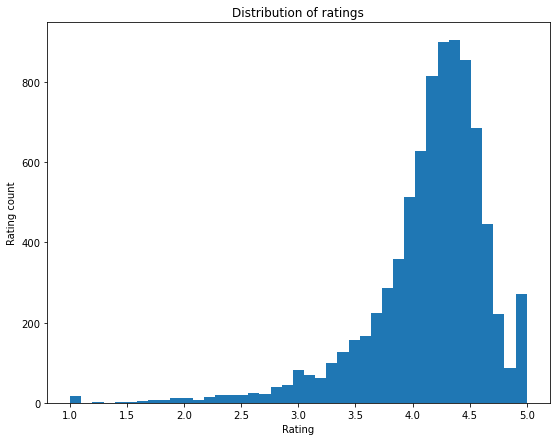

In [45]:
plt.figure(figsize=(9, 7))
plt.hist(play_store_data.rating, bins=41)
plt.title("Distribution of ratings")
plt.xlabel("Rating")
plt.ylabel("Rating count")
plt.show()

In [46]:
play_store_data.rating.skew()

-1.750854266143134

The "rating" distribution is very negatively skewed, but the bigger problem is that it is imbalanced. I can guess that the learning algorithms will learn very well what makes an app good, but when a 1.2 star app comes by, problems will arise.

‎

‎
<span style="font-size:25px;">In an older version.</span>

Sooo, somehow previously I had decided that there are 50 numbers between 10 and 50. How? I have no idea. And so my graph looked like this: (hist with 50 bins)

![123](https://imgur.com/RVTgrYa.png)

And I was so perplexed why this was so, I had written this bellow, and even later tried to impute the missing values. Absolute idiot :D

_Very interesting histogram. Why are there some ratings with 0 counts? Are the missing values disrupting the distribution? - Yes, but not by this much, if say we add the ~1500 missing values, there would still be holes._

‎

_Is the human factor at play? Maybe some ratings are less likely to be chosen by a human, just like some cards when we are asked to choose from a deck. Or this might be "the wisdom of the crowd" effect - when we rate an app, we can see what other people have rated it before us, which will inevitably somewhat skew our choice. There is a cool example from "The data science design manual". Say we have a big jar full with pennies and ask people to guess how many pennies there are in the jar. The jar has exactly 1879 pennies. The first 11 people guessed:_

$$ [573, 556, 600, 636, 1200, 1250, 2350, 3000, 5000, 11000, 15000] $$

_These values have a median of 1250 and a mean equal to 3739. But the second 12 people guessed:_

$$ [750, 750, 1000, 1000, 1000, 1250, 1400, 1770, 1800, 3500, 4000, 5000] $$

_The previous guesses strongly influenced the second 12. The group eliminated the outliers immediately. Now the median is equal to 1325 and the mean is 1935. The group got scary close to guessing the number, although no one individually got very close._

‎

_It could be simple mathematics, maybe it is harder to express these particular numbers with a combination of {1, 2, 3, 4, 5} divided by their count._

In the end the human factor really was in play, a human that cannot count. :D

‎

How does the distribution of "**days_since_last_updated**"?

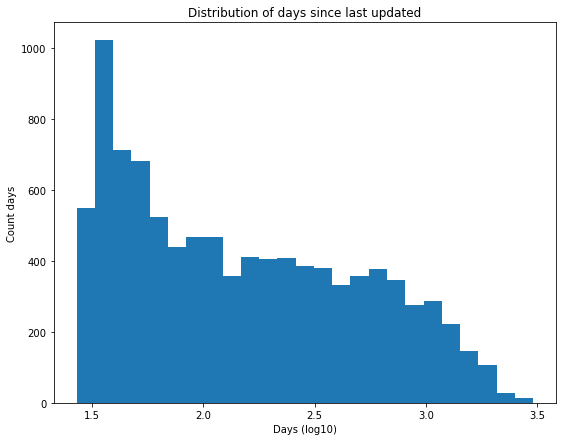

In [47]:
plt.figure(figsize=(9, 7))
plt.hist(np.log10(play_store_data.days_since_last_update), bins="fd")
plt.title("Distribution of days since last updated")
plt.xlabel("Days (log10)")
plt.ylabel("Count days")
plt.show()

A lot of apps were updated recently, but there is a considerable amount that have not been receiving that dev love uwu.

‎

I want some insight on the missing values. Should I impute or drop them? In order to do drop rows with NaN, there must not be a pattern in the missing data. Are there categories that have more missing values than others? Investigation is below.

In [48]:
def pcnt_missing_data_per_cat_in_col(df, column_w_missing_data, col_to_group_by):
    """
    Get percentage missing data per items in non-continious column.
    """
    percent_missing_per_category = {}
    
    for category, group_data in df.groupby(col_to_group_by):
        res = group_data[column_w_missing_data].isna().sum() / len(group_data[column_w_missing_data])
        percent_missing_per_category[category] = res
    
    percent_missing_per_category = pd.Series(percent_missing_per_category).sort_values()
    
    return percent_missing_per_category

In [49]:
def plot_barh(data, title, xlabel, ylabel, size=(10, 9)):
    plt.figure(figsize = size)
    plt.barh(data.index.astype(str), data.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [50]:
percent_missing_ratings_per_category = pcnt_missing_data_per_cat_in_col(play_store_data, "rating", "category")

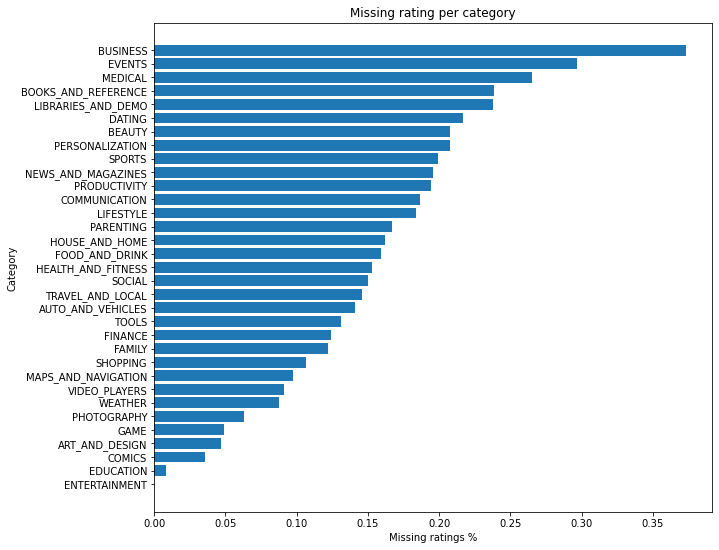

In [51]:
plot_barh(percent_missing_ratings_per_category, "Missing rating per category", "Missing ratings %", "Category")

In [52]:
print(f"Missing on average: {percent_missing_ratings_per_category.mean()*100:.3f}%")

Missing on average: 15.282%


In [53]:
print(f"Standart deviation: {percent_missing_ratings_per_category.std()*100:.3f}%")

Standart deviation: 8.260%


‎

There are missing values in all categories except for one. On average there are 15% (+-8%) missing rating per category. If we decide to outright drop all rows with missing values, we might introduce a bias. 

‎

In [54]:
percent_missing_ratings_per_installs = pcnt_missing_data_per_cat_in_col(play_store_data, "rating", "installs")

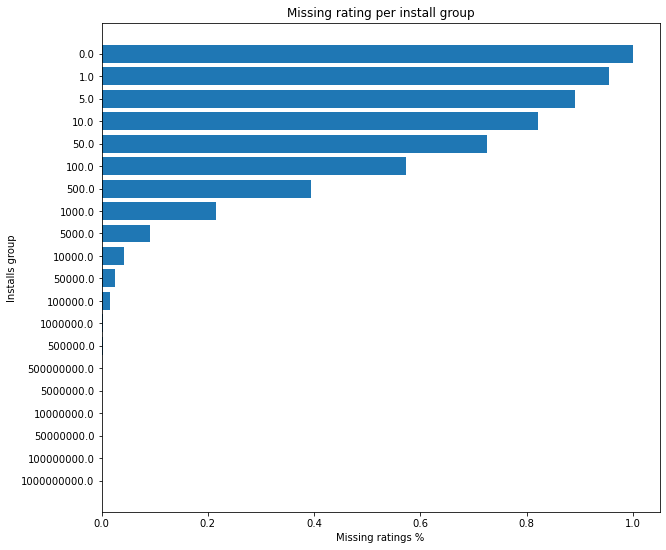

In [55]:
plot_barh(percent_missing_ratings_per_installs, "Missing rating per install group", "Missing ratings %", "Installs group")

‎

Now this is an interesting insight, and a veeeeery logical at that. *Apps that have not been downloaded have no reviews*. But apps that have been downloaded by 1000+ people and no-one left a review, that is a bit odd. For these low downloads apps to be useful for evaluating the performance of a learning algorithm, we need to check against something. There are two paths, both flawed in my opinion.

1. **Remove** the missing data.
    * There really happens to be a systematic reason for the missing data. Removing it will certainly introduce a bias. Filling it up with a lousy model will create garbage and in return give garbage back, so maybe it is best to remove them anyways.
    * There is missing data in the dependable variable. I could not find a concrete answer online whether imputing the target variable is a good idea. I myself see some problems in this particular case. The data set is very imbalanced, and thus the imputed values will most certainly just look like training data. I think of it as knowing only what dogs look like, and trying to draw a cat afterwards, well "the cat" will most certainly look very much like a dog and then trying to learn what a cat is from pictures that look like dogs... maybe I am wrong, and this applies only to some kinds of imputation strategies.


2. **Impute** the missing ratings.
   1. Mean, mode, etc.
   2. Kmeans or another algorithm.
       * The apps with less downloads are more interesting to me. If an app has a lot of downloads it probably has a high rating. A real world use case of the project could be to just pluck in the numbers and see how well received your app idea might be. An app with 100 000 downloads is probably doing fine, but I want to find diamonds in the rough. If we remove the data, we lose this very valuable learning experience.

‎

**Final thoughts**: If we remove the missing data, we create bias by losing learning experience on the "low install" apps. If we impute the data, the imputed values will be more of the same, thus making the data set even more imbalanced, and also kinda losing experience on the "low install" apps. Imputing the target also makes pipelines unusable...
       
‎
**I will NOT be imputing rows with a missing target. (although originally I had made it work, but it was ultra botched)...**

‎

Continuing to "size_M". Do some categories have more missing values than others?

‎

In [56]:
percent_missing_size_per_category = pcnt_missing_data_per_cat_in_col(play_store_data, "size_M", "category")

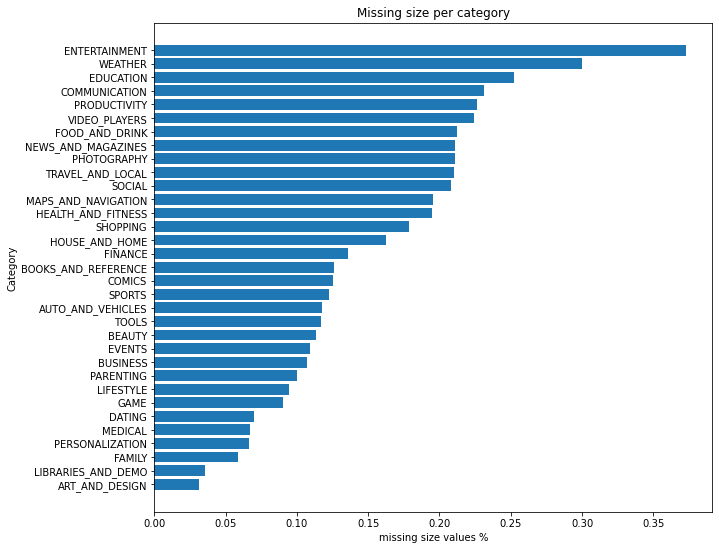

In [57]:
plot_barh(percent_missing_size_per_category, "Missing size per category", "missing size values %", "Category")

In [58]:
print(f"Missing on average: {percent_missing_size_per_category.mean()*100:.3f}%")

Missing on average: 15.386%


In [59]:
print(f"Standart deviation: {percent_missing_size_per_category.std()*100:.3f}%")

Standart deviation: 7.847%


Nothing too crazy, every category has missing values - 15% missing on average with a std of 7%.

‎

What about installs? The column "installs" should contain continuous values, but in this data set "installs" is almost like a categorical column. How do apps with more and less downloads compare to each other based on missing values?

‎

In [60]:
percent_missing_size_per_installs = pcnt_missing_data_per_cat_in_col(play_store_data, "size_M", "installs")

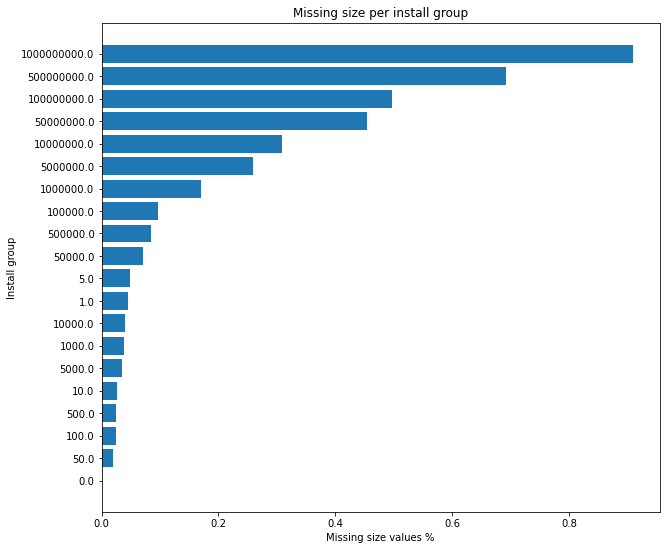

In [61]:
plot_barh(percent_missing_size_per_installs, "Missing size per install group", "Missing size values %", "Install group")

‎

Almost all of the most downloaded apps have missing size. I suppose these were "Varies with device" since these apps are supported across many phone brands. These could be imputed by just going on the actual Google play store and checking the size, or making a crawler just for them.

‎

The categorical column "content_rating" could be an interesting one. Let's take a look.

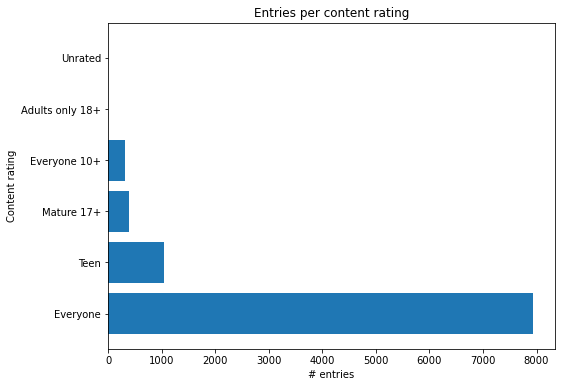

In [62]:
content_rating_counts = play_store_data.content_rating.value_counts()

plt.figure(figsize = (8, 6))
plt.barh(content_rating_counts.index, content_rating_counts.values)
plt.title("Entries per content rating")
plt.xlabel("# entries")
plt.ylabel("Content rating")
plt.show()

‎

The categories here have a lot of overlap, and most apps are for everyone. The venn diagram of "content_rating" will look veeery messy. This column is not very informative and I will drop it.

‎

In [63]:
play_store_data = play_store_data.drop(columns="content_rating")

‎

Genres has way to many categories which will be a pain to encode. Also "category" already has basically the same information. I will drop it in favor of "category".

‎

In [64]:
len(play_store_data.genres.unique())

119

In [65]:
play_store_data = play_store_data.drop(columns="genres")

#### 2.2.2. Correlation matrix.

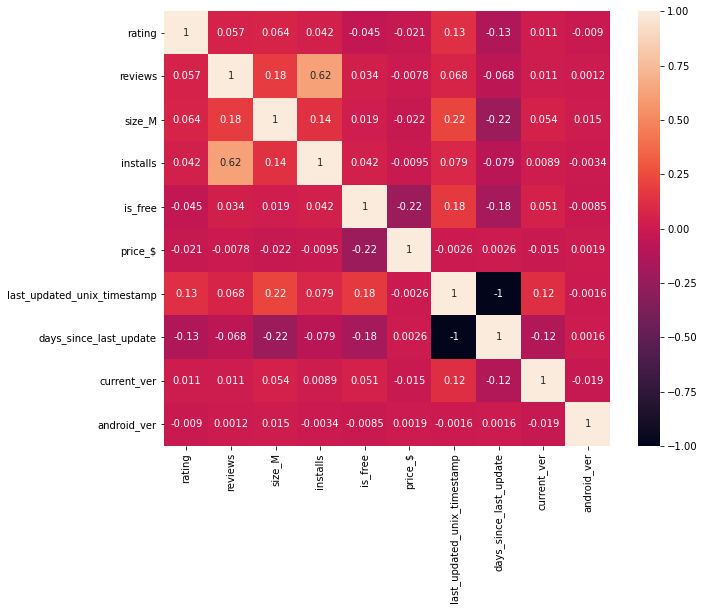

In [66]:
corr_matrix = play_store_data.corr()
plt.figure(figsize=(10, 8))
sn.heatmap(corr_matrix, annot=True)
plt.show()

‎

First thing I notice is that "**days_since_last_update**" and "**last_updated_unix_timestamp**" seem to bring the same amount of information (with a different sign which is interesting), although I was pretty sure "**days_since_last_update**" would be more informative. I will remove "**last_updated_unix_timestamp**", because it is  a much bigger number, but brings the same information.

‎

In [67]:
play_store_data = play_store_data.drop(columns=["last_updated_unix_timestamp", "last_updated"])

‎

* There is a relatively strong linear correlation between "**installs**" and "**reviews**". This is explainable, as we saw, if more people try the app, more people will leave feedback.

* "**days_since_last_update**" and "**size_M**" have somewhat of a relation ship, apps that have been updated recently are bigger in size.

* "**android_ver**" is borderline garbage. I am tempted to drop it, but there might be a strange non-linear correlation with the target column.

‎

The "app" column is of no use to the learning algorithms, so I drop it. Firstly the column "category" must be encoded in a "one hot encoder" style.

In [68]:
play_store_data = play_store_data.drop(columns="app")

# 3. ML.
## 3.1 Some prep work.

Bellow is the usual ML preparation:
1. Attributes and target separation.
2. Train, test split.

‎

In [69]:
# remove rows with missing target.
ps_ml_data = play_store_data[play_store_data["rating"].notna()]

In [70]:
ps_ml_data.shape

(8240, 10)

‎

Usually in a regression problem it is impossible to do a stratified split, since the target is a continuous variable. In this data set the target is also continuous, but has 41 distinct values. One of the requirements is every one of the 41 distinct values must have at lest 2 instances, that is true for every rating except for "1.2", which has only one example in the data set. I think it is best that we drop this single one, do a stratified split, and not risk getting splits which lack examples of some ratings.

‎

In [71]:
# remove the single app with a 1.2 rating.
ps_ml_data = ps_ml_data[ps_ml_data.rating != 1.2]

In [72]:
# separate X, y.
ps_atts = ps_ml_data.drop(columns="rating")
ps_target = ps_ml_data.rating

In [73]:
# train, test split
ps_att_train, ps_att_test, ps_target_train, ps_target_test = train_test_split(ps_atts, 
                                                                              ps_target, 
                                                                              test_size = 1000,
                                                                              stratify=ps_target, 
                                                                              random_state = 1234)

ps_att_train.shape, ps_att_test.shape, ps_target_train.shape, ps_target_test.shape

((7239, 9), (1000, 9), (7239,), (1000,))

‎

A simple pipeline will do the job of:
   1. One hot encoding the categorical columns.
   2. Scaling the numeric data.
   3. Imputing the missing values with KNN.
   4. Modeling.

‎

In [74]:
def GetDumies(df):
    return pd.get_dummies(df)

In [75]:
model = None
main_pipe = make_pipeline(FunctionTransformer(GetDumies),
                          MinMaxScaler(),
                          KNNImputer(),
                          model)

‎

## 3.2 Linear regression (base line).

‎

In [76]:
def exchange_model(pipe, model):
    """
    Swap out the last step of a pipeline.
    """
    pipe.steps.pop()
    pipe.steps.append([model.__class__.__name__, model])
    return pipe

In [77]:
# main_pipe.get_params().keys()

‎

**Linear regression** will be my baseline model, it is important to be able to compare the more "advanced" model with something simple. In the grid search is included the "n_neighbors" hyper-parameter, because we do not actually know if the default value is the best one.

For metrics I chose "**mean absolute error**" which is very easy to interpret, and for good measure (no pun intended) - "**mean squared error**".

The other important evaluation tool is the **residual plot**.

‎

In [78]:
base_pipe = exchange_model(main_pipe, LinearRegression())

grid = {
    "knnimputer__n_neighbors" : [3, 5, 7, 14],
    "LinearRegression__fit_intercept" : [True, False],
}

linear_model = GridSearchCV(base_pipe, grid, scoring="neg_mean_squared_error", n_jobs=-1).fit(ps_att_train, ps_target_train)

In [79]:
linear_model.best_params_

{'LinearRegression__fit_intercept': False, 'knnimputer__n_neighbors': 3}

‎

The results from the baseline model are actually not that bad. I will want to save the test and train scores of each model so that I can compare them directly in a chart later.

‎

In [80]:
linear_model.best_score_

-0.2737481407158776

In [81]:
linear_model.cv_results_

{'mean_fit_time': array([2.32415724, 1.99709425, 1.697541  , 1.64057612, 1.71430068,
        1.66750774, 1.738797  , 1.46517181]),
 'std_fit_time': array([0.0350767 , 0.47374275, 0.44990862, 0.41332514, 0.48359542,
        0.52714774, 0.44682468, 0.34736344]),
 'mean_score_time': array([0.4186656 , 0.39551387, 0.45212107, 0.40035105, 0.40329523,
        0.41875901, 0.40554881, 0.21027699]),
 'std_score_time': array([0.09851805, 0.11307494, 0.13699429, 0.13233456, 0.11530665,
        0.10036089, 0.09665072, 0.07300539]),
 'param_LinearRegression__fit_intercept': masked_array(data=[True, True, True, True, False, False, False, False],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_knnimputer__n_neighbors': masked_array(data=[3, 5, 7, 14, 3, 5, 7, 14],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'LinearRe

‎

Variation between the cross validation scores is fine. Now finally how did we do the final test?

‎

In [82]:
def get_scores(model, X_test, y_test, print_out=True):
    MSE = mean_squared_error(y_test, model.predict(X_test))
    MAE = mean_absolute_error(y_test, model.predict(X_test))
    if print_out:
        print(f"MSE: {MSE}")
        print(f"MAE: {MAE}")
    return [MSE, MAE]

In [83]:
get_scores(linear_model, ps_att_test, ps_target_test)

MSE: 0.2766248859559146
MAE: 0.3695039522761011


[0.2766248859559146, 0.3695039522761011]

For a baseline model, the results are not that bad.

‎

Save the scores for comparison later.

In [84]:
model_scores = dict()
model_scores["baseline_LogRes"] = get_scores(linear_model, ps_att_test, ps_target_test, print_out=False)

In [85]:
def plot_residuals(model, X, y):
    predicted = model.predict(X)
    plt.figure(figsize=(10, 8))
    plt.scatter(predicted, y - predicted)
    plt.axline((min(predicted), 0), (max(predicted), 0), linewidth=3, color='r', alpha=0.7, ls="--")
    plt.title(f"Residual plot ({model.best_estimator_[-1].__class__.__name__})")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.show()

**NOTE: The title of all residual plots should not be "actual vs predicted"! The should be either called just "Residual plot" or "Residual vs predicted". I fixed it in the code, but I already ran the notebook and do not want to mess up the numbering of the columns.**

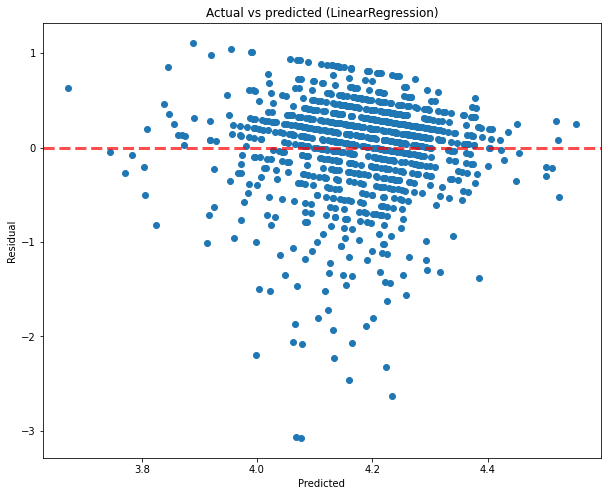

In [86]:
plot_residuals(linear_model, ps_att_test, ps_target_test)

Several things to note here.

* There seems to be some inverse **heteroscedasticity**. As the the predictions get smaller, the residuals get bigger. This could be due to dropping the low downloads app, or the imbalance of the data set.

* The model makes predictions in the **range (3.6, 4.5)**, but app ratings can range from 1 to 5. Well this is expected since the model has barely seen any 1 or 2 star apps.

* And because of the point above, the model systematically **rates highly** low performing apps, hence the values around -2 and -3.

* There kinda is a *leftover linear function*, maybe my eyes are tricking me...

‎

## 3.2 Linear regression with regularization.

‎

This is basically the base model but with regularization. Now as I look at it, seem like a bit of a waste, the baseline model was not over-fitting anyways. But since I already wrote it I won't remove it.

In [87]:
elastic_net_pipe = exchange_model(main_pipe, ElasticNet())

grid = {
    "knnimputer__n_neighbors" : [5, 7, 9],
    "ElasticNet__alpha" : [1e-3, 1e-2, 1, 1e3],
    "ElasticNet__l1_ratio" : [0, 0.5, 1, 2],
    "ElasticNet__fit_intercept" : [True, False],
}

elastic_net_model = GridSearchCV(elastic_net_pipe, grid, scoring="neg_mean_squared_error", n_jobs=-1).fit(ps_att_train, ps_target_train)

C:\Users\Tzvetomir\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
C:\Users\Tzvetomir\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 983.8585171854444, tolerance: 0.20702434231247407
  positive)


In [88]:
elastic_net_model.best_params_

{'ElasticNet__alpha': 0.001,
 'ElasticNet__fit_intercept': True,
 'ElasticNet__l1_ratio': 0,
 'knnimputer__n_neighbors': 5}

In [89]:
elastic_net_model.cv_results_

{'mean_fit_time': array([2.35533752, 2.72685966, 2.2870018 , 1.93233223, 1.69006457,
        1.82954664, 1.80130205, 1.82379985, 2.19727936, 1.79863658,
        1.69750805, 1.79251394, 2.29278588, 2.27877951, 2.324507  ,
        1.84409537, 1.77275987, 1.83351669, 1.75888968, 1.73749714,
        1.66635289, 2.12673635, 2.23003139, 2.20682302, 2.54051142,
        2.42929702, 2.35912867, 1.77692208, 1.79035087, 1.71213603,
        1.72943664, 1.67493825, 1.54070807, 1.59975414, 1.57159572,
        1.64520459, 2.23943901, 2.41779518, 2.41450624, 1.96371212,
        1.72688169, 1.69840846, 1.70881329, 1.72642283, 1.76342115,
        1.72663565, 1.60474663, 1.79365478, 2.20024118, 2.39885726,
        2.38723264, 1.81438975, 1.70447631, 1.58150969, 1.77647958,
        1.63902893, 1.7119751 , 1.66056037, 1.82206082, 1.77261   ,
        2.23096242, 2.32685099, 2.65778613, 1.94726472, 1.51678848,
        1.64633269, 1.5073072 , 1.72377167, 1.71776261, 2.16760793,
        2.39759889, 2.0392324 ,

In [90]:
elastic_net_model.best_score_

-0.2735561539352308

In [91]:
get_scores(elastic_net_model, ps_att_test, ps_target_test)

MSE: 0.27720742552109623
MAE: 0.36996456830206215


[0.27720742552109623, 0.36996456830206215]

In [92]:
model_scores["elastic_net"] = get_scores(elastic_net_model, ps_att_test, ps_target_test, print_out=False)

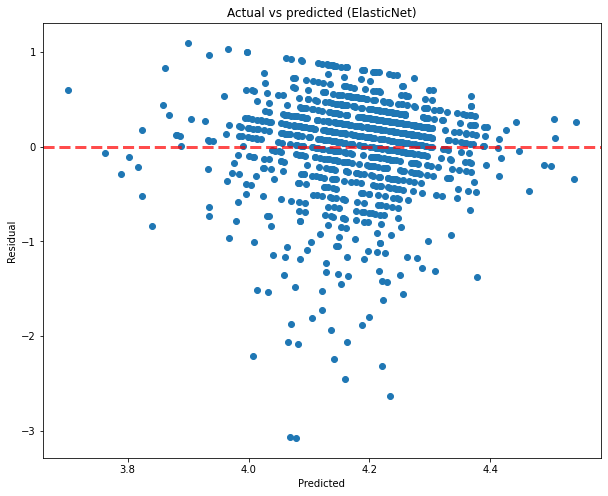

In [93]:
plot_residuals(elastic_net_model, ps_att_test, ps_target_test)

The residual plot looks almost exactly like the previous one and exhibits the same problems.

‎

## 3.3 Random forest regression.

‎

Random forest are one of the best classifiers, but I do not know if that is true about regression. For a random forest do be effective it basically requires 2 things - many trees and the trees being shallow. And thus the chosen hyperparameters.

In [94]:
RFR_pipe = exchange_model(main_pipe, RandomForestRegressor())

grid = {
    "knnimputer__n_neighbors" : [5, 7, 9],
    "RandomForestRegressor__n_estimators" : [100, 200, 300],
    "RandomForestRegressor__max_depth" : [2, 3, 5, 7],
}

RFR_model = GridSearchCV(RFR_pipe, grid, scoring="neg_mean_squared_error", n_jobs=-1).fit(ps_att_train, ps_target_train)

In [95]:
RFR_model.best_params_

{'RandomForestRegressor__max_depth': 7,
 'RandomForestRegressor__n_estimators': 100,
 'knnimputer__n_neighbors': 5}

In [96]:
RFR_model.best_score_

-0.2514526818098195

In [97]:
RFR_model.cv_results_

{'mean_fit_time': array([ 2.36379452,  2.3154613 ,  2.38344331,  2.90977931,  3.02172303,
         3.18642259,  3.81397696,  3.83792987,  3.82577882,  2.51552086,
         2.69606652,  2.51388092,  3.70588288,  3.5355679 ,  3.63070045,
         4.62761445,  4.51778326,  4.61458573,  3.12101407,  3.10972595,
         3.23329101,  4.8530026 ,  4.67749429,  4.79771895,  6.40988922,
         6.39849386,  6.42275209,  3.71436558,  3.68158164,  3.88310242,
         5.98409147,  6.92939925,  7.557618  , 10.19872875, 10.23210759,
         9.28313904]),
 'std_fit_time': array([0.30299848, 0.34501778, 0.37950105, 0.2332296 , 0.29698383,
        0.27390431, 0.36811483, 0.34214017, 0.33406593, 0.28668907,
        0.42432854, 0.32017544, 0.35134946, 0.27801811, 0.3552946 ,
        0.26510932, 0.24091273, 0.33200259, 0.43245182, 0.24640027,
        0.3673348 , 0.40203172, 0.26676191, 0.37717288, 0.26913188,
        0.38869392, 0.30793581, 0.31813969, 0.23490492, 0.4091333 ,
        0.28339634, 0.342

In [98]:
get_scores(RFR_model, ps_att_test, ps_target_test)

MSE: 0.2510951770513907
MAE: 0.34419869574990103


[0.2510951770513907, 0.34419869574990103]

‎

This is a substantial step up in the scores of the linear models.

‎

In [99]:
model_scores["RFR_model"] = get_scores(RFR_model, ps_att_test, ps_target_test, print_out=False)

In [100]:
for column, importance in zip(pd.get_dummies(ps_att_test).columns, 
                              RFR_model.best_estimator_["RandomForestRegressor"].feature_importances_):
    print(column, importance)

reviews 0.2711053851671361
size_M 0.08311000069672858
installs 0.18731023194345564
is_free 0.004947476286164858
price_$ 0.04575365590654356
days_since_last_update 0.18048177977847477
current_ver 0.07611597551675103
android_ver 0.0
category_ART_AND_DESIGN 2.757294261114322e-05
category_AUTO_AND_VEHICLES 0.00496387853310639
category_BEAUTY 9.565670682530145e-05
category_BOOKS_AND_REFERENCE 0.0029833836414313404
category_BUSINESS 0.007411380867758014
category_COMICS 0.002354649766989915
category_COMMUNICATION 0.004633238089374691
category_DATING 0.010482191262974028
category_EDUCATION 0.00026625419517805346
category_ENTERTAINMENT 0.0012192522362041705
category_EVENTS 0.0010914738089899706
category_FAMILY 0.00731340528941389
category_FINANCE 0.007370507875937028
category_FOOD_AND_DRINK 0.001848318296256413
category_GAME 0.00252597390678619
category_HEALTH_AND_FITNESS 0.014075241933056197
category_HOUSE_AND_HOME 2.6482277929862672e-05
category_LIBRARIES_AND_DEMO 0.0004959947772689828
catego

‎

One of the awesome perks of "random forests" is that we can examine the feature importances. It is no surprise that 
"reviews" and "installs" are the most important out of the bunch. "android_ver" on the other hand is borderline useless. Also "current_ver" is somehow more important than "price_$" which is interesting.

‎

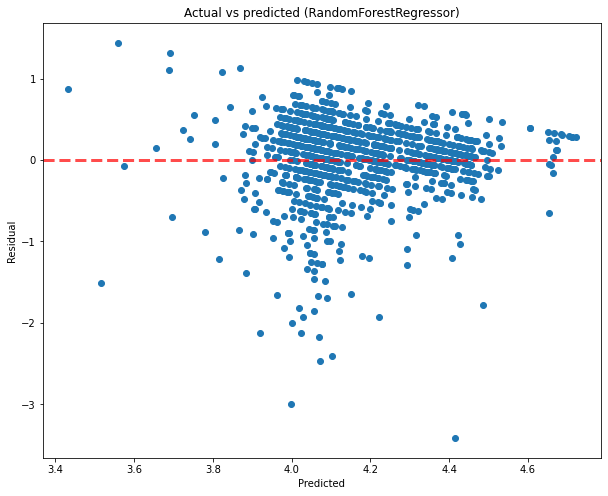

In [101]:
plot_residuals(RFR_model, ps_att_test, ps_target_test)

This plot does not look too good, but at least the model tried to guess something as a low rated app, and failed miserably xD. The same problems still occur: heteroscedasticity, too high predictions.

‎

## 3.4 Support Vector Regression.

Are we at the limit of the data set, or are the model not complicated enough? Well there is one way to find out. RELEASE THE KRAKEN... I mean the SVR.

‎

### 3.4.1 Polynomial kernel.
Let's first start with the simpler polynomial kernel and move on to "rbf".

‎

In [102]:
svr_poly_pipe = exchange_model(main_pipe, SVR())

grid = {
    "knnimputer__n_neighbors" : [5, 7],
    "SVR__kernel" : ["poly"],
    "SVR__C" : [1e-2, 1, 1e2, 1e3],
    "SVR__degree" : [0.5, 2, 3],
}

svr_poly_model = GridSearchCV(svr_poly_pipe, grid, scoring="neg_mean_squared_error", n_jobs=-1).fit(ps_att_train, ps_target_train)

In [103]:
svr_poly_model.best_params_

{'SVR__C': 1,
 'SVR__degree': 2,
 'SVR__kernel': 'poly',
 'knnimputer__n_neighbors': 5}

In [104]:
svr_poly_model.best_score_

-0.2802673793204746

In [105]:
get_scores(svr_poly_model, ps_att_test, ps_target_test)

MSE: 0.28736584739677584
MAE: 0.35839082775885445


[0.28736584739677584, 0.35839082775885445]

In [106]:
model_scores["svr_poly_model"] = get_scores(svr_poly_model, ps_att_test, ps_target_test, print_out=False)

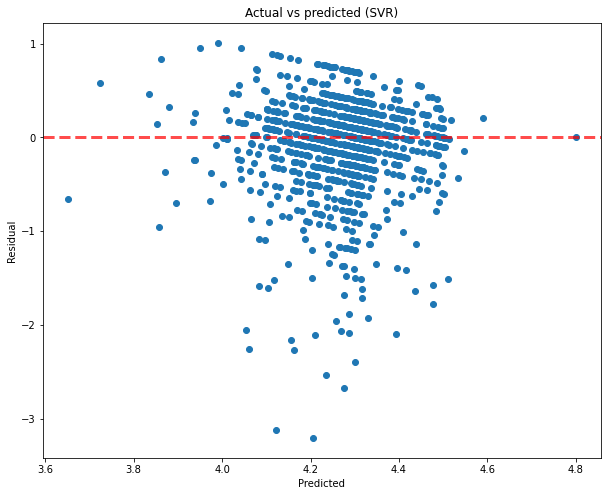

In [107]:
plot_residuals(svr_poly_model, ps_att_test, ps_target_test)

This is the same picture. :(

‎

### 3.4.2. RBF kernel.

‎

The radial basis kernel heavily relies on "C" and "gamma". There are a couple of things to watch out for:

* If gamma is too large the area of influence will be very small. This will lead to over-fitting. 
* If gamma is too small, it cannot capture the complexity of the data and performs similarly to a linear model.

There is a golden diagonal of values where, gamma is small and has a big area of influence, but is then made more complex with a large "C" value.

‎

In [108]:
svr_rbf_pipe = exchange_model(main_pipe, SVR())

grid = {
    "knnimputer__n_neighbors" : [5, 9],
    "SVR__C" : [0.1, 1, 10, 100, 1e3],
    "SVR__gamma" : [0.01, 0.1, 10],
}

svr_rbf_model = GridSearchCV(svr_rbf_pipe, grid, scoring="neg_mean_squared_error", n_jobs=-2).fit(ps_att_train, ps_target_train)

In [109]:
svr_rbf_model.best_score_

-0.279870958563713

In [110]:
svr_rbf_model.best_params_

{'SVR__C': 10, 'SVR__gamma': 0.1, 'knnimputer__n_neighbors': 5}

In [111]:
get_scores(svr_rbf_model, ps_att_test, ps_target_test)

MSE: 0.28593858624028184
MAE: 0.3574862719533619


[0.28593858624028184, 0.3574862719533619]

In [112]:
model_scores["svr_rbf_model"] = get_scores(svr_rbf_model, ps_att_test, ps_target_test, print_out=False)

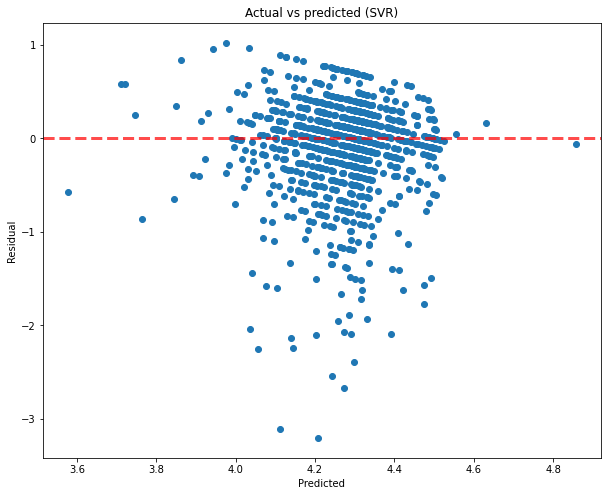

In [113]:
plot_residuals(svr_rbf_model, ps_att_test, ps_target_test)

‎

Unfortunately, It seems that we have reached the maximum that that the data can offer. The residual plot has not changed that much. Which model did the best? Also, I will add some of the results where I imputed the missing targets.

‎

In [114]:
model_scores["RFR_target_imp"] = [0.2157782061172474, 0.323390160459778]
model_scores["Baseline_targrt_imp"] = [0.2246157376000772, 0.33322336398608565]

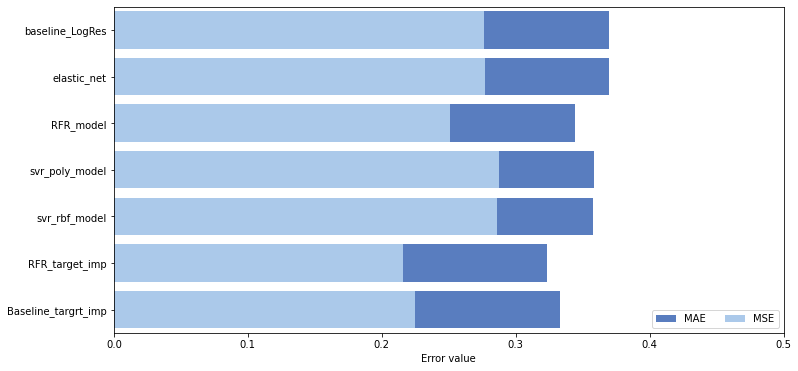

In [115]:
model_scores = pd.DataFrame(model_scores).T

f, ax = plt.subplots(figsize=(12, 6))

sn.set_color_codes("muted")
sn.barplot(x=1, y=model_scores.index, data=model_scores,
            label="MAE", color="b")

sn.set_color_codes("pastel")
sn.barplot(x=0, y=model_scores.index, data=model_scores,
            label="MSE", color="b")

ax.legend(ncol=2, loc="lower right")

sn.set_color_codes("deep")

ax.set(ylabel="", xlabel="Error value")
ax.set_xlim((0, 0.5))
plt.show()

The results where I imputed the target actually have pretty good results comparatively, but the solution was ultra botched. From the new ones **random forest regression** came on top, but by a quite small margin. I will proceed to place the best model in a jar with vinegar and asperin.

‎

In [116]:
pickle.dump(RFR_pipe, open('RFR_pipe.pkl', 'wb'))

‎

## 4. Previous work.

There are several really good notebooks on this data set in "kaggle". This one I found most notable: https://www.kaggle.com/jemseow/machine-learning-to-predict-app-ratings/comments

It is well written and we have some results that we can directly compare to (marked with a red line).

![other_work](https://imgur.com/n82cimT.jpg)

In the cases where I imputed the target variable my results are better, also I could have squeezed a bit more of my data if I had included "genres". Also here is a well made EDA on the same data set: https://www.kaggle.com/data13/machine-learning-model-to-predict-app-rating-94,  https://www.kaggle.com/jemseow/machine-learning-to-predict-app-ratings

‎

# Time for a classification problem.

‎

Short, but **important** story.

When I started the project, I had collected from kaggle 2 very similar datasets, both about apps on the app store. I wanted to predict the rating of an app for both of them, but also somehow have examples of regression and classification. Long story short - trying to predict app ratings with classification was a complete failure, so I ditched it. I had to predict something more suitable, and of course that is the category of an app. The problem is that this new part no longer answers the main question of the project directly.

Also, the old classification part which I messed up badly is still interesting, and decided to leave it in a crude, half finished, state at the end of the notebook. It was a valuable experience, especially interesting (at least to me) is the part when I realized where the unfixable problem is.

## 600k apps data set - Are categories really separable?

## 1. Data wrangling.

### 1.1. Reading the data.

In [117]:
apps_600k_data = pd.read_csv("data/google_ps_600k.csv")

In [118]:
apps_600k_data.shape

(603047, 23)

In [119]:
apps_600k_data.head(3)

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice
0,foodpanda - Local Food & Grocery Delivery,com.global.foodpanda.android,Food & Drink,4.4,1258493.0,"10,000,000+",10000000.0,48828081,True,0.0,...,Foodpanda GmbH a subsidiary of Delivery Hero SE,http://foodpanda.com,appsupport@foodpanda.com,"Nov 19, 2013",1594061045000,Everyone,https://www.foodpanda.sg/contents/privacy.htm,False,False,False
1,"Tripadvisor Hotel, Flight & Restaurant Bookings",com.tripadvisor.tripadvisor,Travel & Local,4.4,1360172.0,"100,000,000+",100000000.0,371284181,True,0.0,...,Tripadvisor,https://www.tripadvisor.com/help,mobilehelp@tripadvisor.com,"Jul 12, 2010",1593700848000,Everyone,https://www.tripadvisor.com/pages/privacy.html,True,False,False
2,Safeway Delivery & Pick Up,com.safeway.shop,Shopping,4.2,5532.0,"500,000+",500000.0,816102,True,0.0,...,"Albertsons Companies, Inc.",http://www.safeway.com,homeshopping@customerservice.safeway.com,"Sep 5, 2013",1594921910000,Everyone,http://www.safeway.com/ShopStores/Privacy-Poli...,False,False,False


‎

There were a lot of repeating rows in the previous data set, but there seem to be none obvious ones here, since the shape of the data frame is the same before and after "drop_duplicates()".

‎

In [120]:
apps_600k_data.drop_duplicates().shape

(603047, 23)

‎

For ease of use the columns names should be pythonified, below I am just reusing this functionality from the first part.

‎

In [121]:
apps_600k_data.columns = pythonify_col_names(apps_600k_data)

apps_600k_data.head(0)

,app_name,app_id,category,rating,rating_count,installs,minimum_installs,maximum_installs,free,price,...,developer_id,developer_website,developer_email,released,last_updated,content_rating,privacy_policy,ad_supported,in_app_purchases,editors_choice


‎

### 1.2. Column diagnosis.

Starting with a quick look at which columns need attention.

‎

In [122]:
info(apps_600k_data)

Column               Data type     Missing #   Missing %
app_name             object        1           0.00%
app_id               object        0           0.00%
category             object        0           0.00%
rating               float64       3760        0.62%
rating_count         float64       3760        0.62%
installs             object        172         0.03%
minimum_installs     float64       172         0.03%
maximum_installs     int64         0           0.00%
free                 bool          0           0.00%
price                float64       0           0.00%
currency             object        181         0.03%
size                 object        0           0.00%
minimum_android      object        491         0.08%
developer_id         object        2           0.00%
developer_website    object        179264      29.73%
developer_email      object        37          0.01%
released             object        32278       5.35%
last_updated         int64         0     

‎

Columns that need fixing.

* installs ➜ "<span style="color:#2aad72">float64</span>"
* free ➜ "<span style="color:#4287f5">int</span>" (binary)
* size ➜ "<span style="color:#2aad72">float64</span>" 
* minimum_android ➜ "<span style="color:#2aad72">float64</span>"
* released ➜ unix time stamp
* ad_supported ➜ "<span style="color:#4287f5">int</span>" (binary)
* in_app_purchases ➜ "<span style="color:#4287f5">int</span>" (binary)
* editors_choice ➜ "<span style="color:#4287f5">int</span>" (binary)

#### 1.2.1. Bool columns.

These columns contain only "False", "True", and can be easily converted to 0, and 1. Also, they have no missing values.

True ➜ 1; False ➜ 0

In [123]:
bool_cols = apps_600k_data.columns[apps_600k_data.dtypes == "bool"]

In [124]:
for col in bool_cols:
    apps_600k_data[col] = apps_600k_data[col].astype("uint8")

‎

#### 1.2.2. size.

For the size column the operations are the same as in the first dataset, even the kilobyte to megabyte function is reused.

* 1,576k ➜ 1.53M

In [125]:
apps_600k_data["size"] = apps_600k_data["size"].str.replace(",", "")
apps_600k_data["size"] = apps_600k_data["size"].apply(convert_k_to_M)
apps_600k_data["size"] = apps_600k_data["size"].replace("Varies with device", np.nan)
apps_600k_data = apps_600k_data.rename(columns={"size" : "size_M"})

‎

#### 1.2.2. minimum_android.

This column was trash in the previous data set, I will not waste time any on it.

‎

In [126]:
apps_600k_data = apps_600k_data.drop(columns=["minimum_android"])

‎

#### 1.2.3. date_released.

Firstly the date must be converted to "datetime64", and then with the help of "stackoverflow", get converted to unix time stamp - something that a model can use.

‎

In [127]:
apps_600k_data.released = pd.to_datetime(apps_600k_data.released)
released_unix_timestamp = (apps_600k_data.released - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
apps_600k_data["released_unix_timestamp"] = released_unix_timestamp

‎

#### 1.2.4. installs.

In the previous dataset this column almost behaved like a categorical one. Well here it still does, but there are 2 additional columns "maximum_installs", "minimum_installs". "maximum_installs" is a lot more granular, and "minimal_installs" is basically the same as installs. There is a small catch, where did "maximum_installs" come from? Is it an actual reading, or some kind of feature engineering? There is a risk of fitting some kind of bias, but I am willing to take it.

‎

## 2. EDA.
### 2.1. Min, max, mean, std of each numeric column.

‎

In [128]:
apps_600k_data.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,599287.0,2.995484e+00,1.911436e+00,0.000000e+00,0.000000e+00,4.000000e+00,4.400000e+00,5.000000e+00
rating_count,599287.0,8.627273e+03,3.467317e+05,0.000000e+00,0.000000e+00,2.900000e+01,2.560000e+02,1.170193e+08
minimum_installs,602875.0,4.997939e+05,2.523102e+07,0.000000e+00,1.000000e+02,5.000000e+03,1.000000e+04,5.000000e+09
maximum_installs,603047.0,8.566150e+05,3.755474e+07,0.000000e+00,4.680000e+02,5.034000e+03,4.346500e+04,9.975727e+09
free,603047.0,9.481583e-01,2.217076e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
price,603047.0,2.488185e-01,3.392709e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+02
size_M,577106.0,1.741276e+01,2.120477e+01,3.222656e-03,4.400000e+00,9.000000e+00,2.200000e+01,9.100000e+02
last_updated,603047.0,1.554565e+12,4.629829e+10,1.239053e+12,1.537884e+12,1.571317e+12,1.588598e+12,1.595487e+12
ad_supported,603047.0,5.430787e-01,4.981412e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
in_app_purchases,603047.0,1.334954e-01,3.401096e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


‎

### 2.2. Corelation matrix.

‎

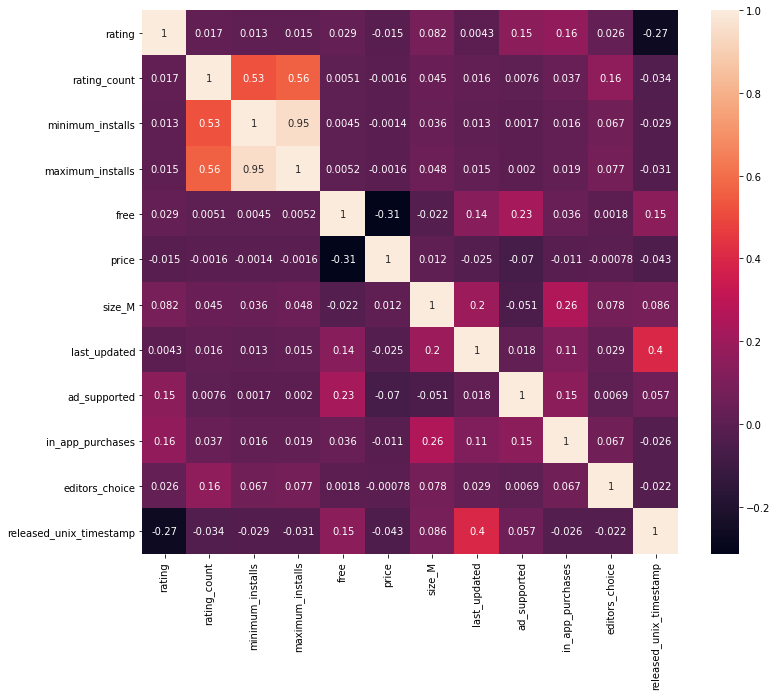

In [129]:
corr_matrix = apps_600k_data.corr()
plt.figure(figsize=(12, 10))
sn.heatmap(corr_matrix, annot=True)
plt.show()

There some noteworthy corelations.
* apps that are installed more are rated by more people. 
* If an app is free it probably has adds.
* "in_app_purchases" and "size_M" is interesting.

Some of these relation could be there just by chance.

‎

### 2.3. Distributions.

#### 2.3.1. "rating".

The fisrt dataset was heavily negatively skewed, this one should be too...

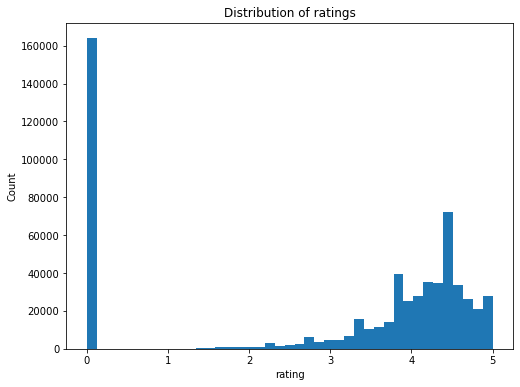

In [130]:
plt.figure(figsize=(8, 6))
plt.hist(apps_600k_data.rating, bins=41)
plt.title("Distribution of ratings")
plt.xlabel("rating")
plt.ylabel("Count")
plt.show()

‎

Well this was unexpected... Why are there **160k** apps with a rating of 0? 

‎

In [131]:
apps_600k_data[apps_600k_data.rating < 1].sample(3)

,app_name,app_id,category,rating,rating_count,installs,minimum_installs,maximum_installs,free,price,...,developer_website,developer_email,released,last_updated,content_rating,privacy_policy,ad_supported,in_app_purchases,editors_choice,released_unix_timestamp
244400,مسجات أدعية اسلامية,com.tbabadev.app43,Books & Reference,0.0,0.0,500+,500.0,792,1,0.0,...,http://tbabadev.blogspot.com/,tbaba@engineer.com,2017-01-23,1485160590000,Everyone,http://tbabadev.blogspot.com/2018/09/PrivacyPo...,1,0,0,1.485130e+09
148778,Путь процветания. Джеймс Аллен,com.renstudio.app.AOXCYDBWNSTLTYTDF,Books & Reference,0.0,0.0,"1,000+",1000.0,1474,1,0.0,...,NaN,renatogandrik@gmail.com,2018-09-06,1541580516000,Everyone,NaN,0,0,0,1.536192e+09
228166,Bellissimo Medical Aesthetics,com.totalloyalty.bellissimo10684,Entertainment,0.0,0.0,10+,10.0,12,1,0.0,...,http://www.totalloyalty.com,developer@totalloyalty.com,2015-08-11,1439308164000,Everyone,http://www.totalloyalty.com/privacy-policy,0,0,0,1.439251e+09


‎

Just like the prevoius dataset, apps that have little downloads do not have ratings. These should have a rating of np.nan and not 0. The same qustion is valid here, what to do with these rows? Preferably I would like to impute them, but with what method. Also I need to check the reasons for "missingness".

‎

In [132]:
apps_600k_data.rating = apps_600k_data.rating.replace(0, np.nan)

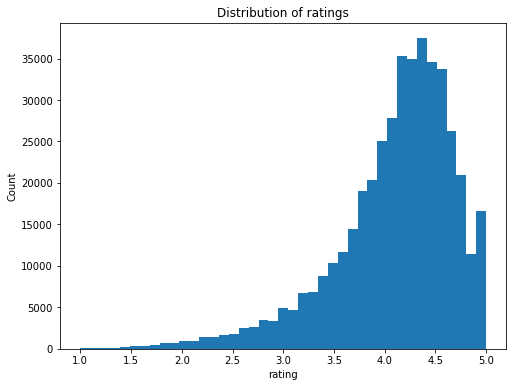

In [133]:
plt.figure(figsize=(8, 6))
plt.hist(apps_600k_data.rating, bins=41)
plt.title("Distribution of ratings")
plt.xlabel("rating")
plt.ylabel("Count")
plt.show()

In [134]:
info(apps_600k_data[["rating"]])

Column    Data type     Missing #   Missing %
rating    float64       167728      27.81%


‎

How do categories differ by rating?

‎

Text(0.5, 1.0, 'Rating quantiles per category')

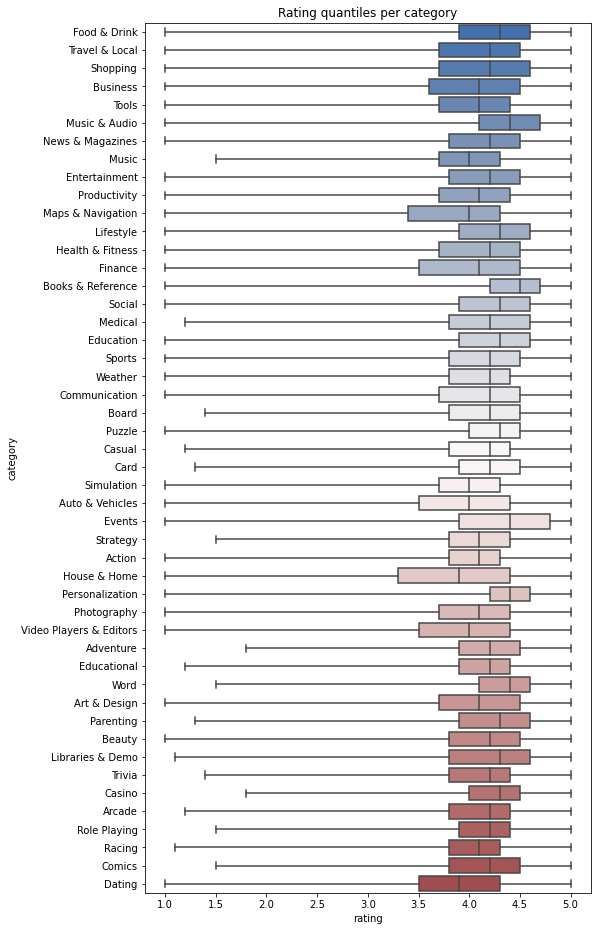

In [135]:
plt.figure(figsize=(8, 16))
sn.boxplot(x="rating", y="category", data=apps_600k_data,
            whis=[0, 100], width=.8, palette="vlag")
plt.title("Rating quantiles per category")

Are these differances significant? This can be determined with ANOVA.

‎

Is there a pattern to the missing rating per category?

In [136]:
pcnt_missing_rating_per_category = pcnt_missing_data_per_cat_in_col(apps_600k_data, "rating", "category")

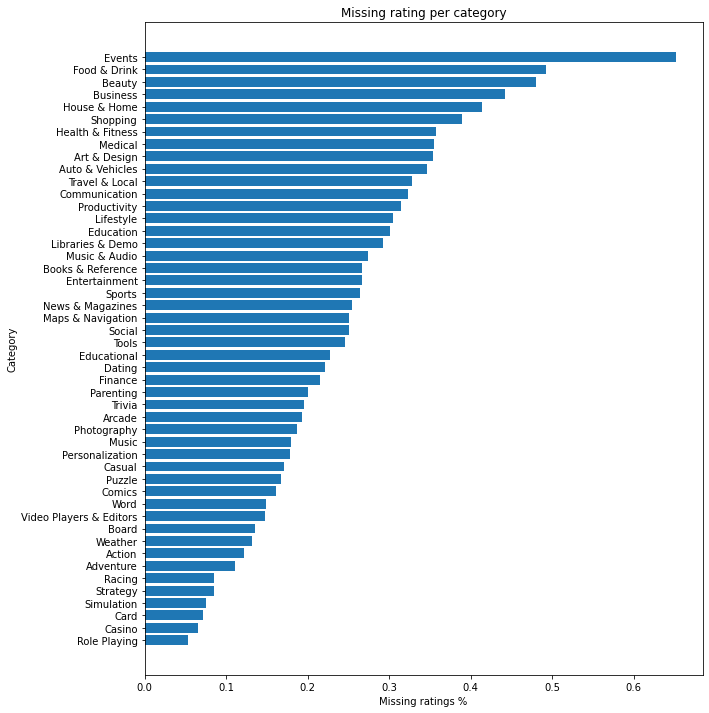

In [137]:
plot_barh(pcnt_missing_rating_per_category, 
          "Missing rating per category", 
          "Missing ratings %", 
          "Category", 
          size=(10, 12))

In [138]:
print(f"Mean: {pcnt_missing_rating_per_category.mean()}")
print(f"std: {pcnt_missing_rating_per_category.std()}")

Mean: 0.2448527310875005
std: 0.1255828631927259


‎

There is a lot more variation.The "Event" category in particular has a lot more missing values that the other categories. This is kinda explainable, some events have a custom app just for them, a limited number of people use them and basically never use them again. Also these apps are downloaded by a small number of people, which as we saw is the main reason for missing ratings. This is probably also the reason for the other categories that have more than average missing values.

#### 2.3.2. installs.

And indeed as seen from the box plot below, "Events" has a lot less install than the other categories, thus the missing ratings. The situation is similar for "Food & Drink", "Beauty" and the other categories with above average missing ratings.

‎

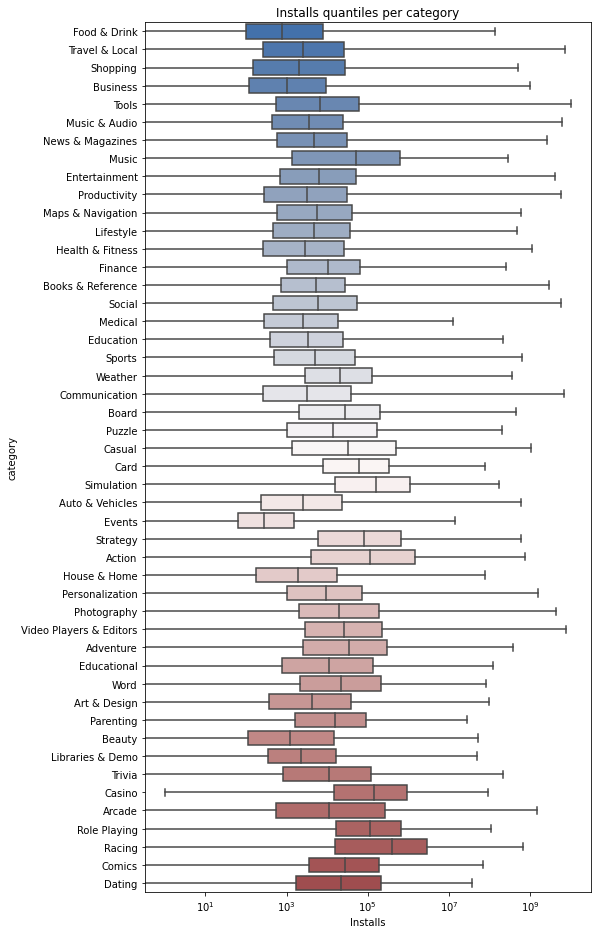

In [139]:
plt.figure(figsize=(8, 16))
plot = sn.boxplot(x="maximum_installs", y="category", data=apps_600k_data, palette="vlag", whis=[0, 100])
plt.title("Installs quantiles per category")
plt.xlabel("Installs")
plot.set_xscale("log")

In [140]:
apps_600k_data[apps_600k_data["category"] == "Events"].maximum_installs.median()

282.0

‎

Just as a sanity check that apps with low install counts have a lot of missing ratings. 

‎

In [141]:
pcnt_missing_rating_per_installs_group = pcnt_missing_data_per_cat_in_col(apps_600k_data, "rating", "installs")

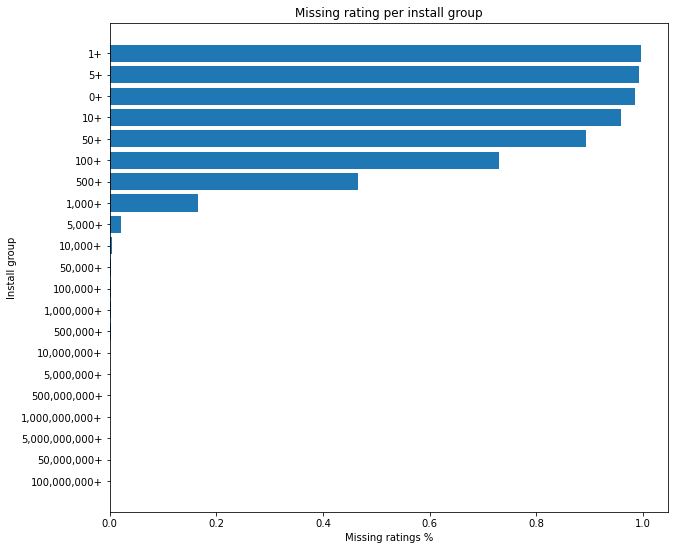

In [142]:
plot_barh(pcnt_missing_rating_per_installs_group, "Missing rating per install group", "Missing ratings %", "Install group")

‎

#### 2.3.3. editors_choice.

What apps do the editors like? :)

‎

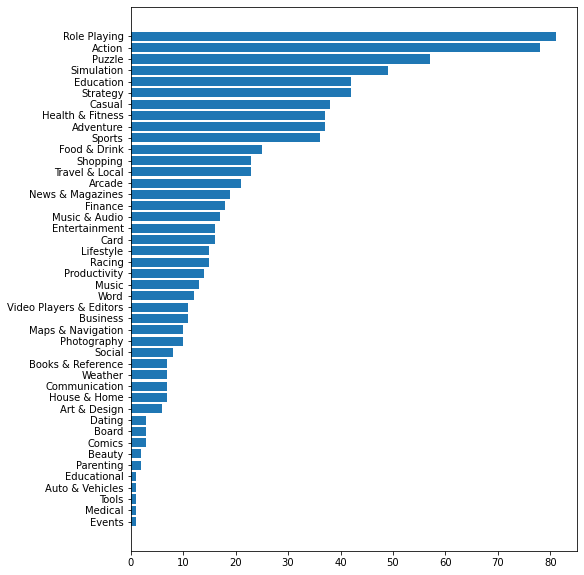

In [143]:
editors_choice_data = apps_600k_data[apps_600k_data.editors_choice == 1]
value_counts = editors_choice_data.category.value_counts(ascending=True)
values = editors_choice_data.category.value_counts(ascending=True).values
cat = editors_choice_data.category.value_counts(ascending=True).index

plt.figure(figsize=(8, 10))
plt.barh(cat, values)
plt.show()

The profile of the editor: Loves role playing and video games, does not date anyone, and hates cars. :D

‎

#### 2.3.4. category.

I do not want to deal with an imbalanced data set again. For the classification problem I will choose the top 3 categories that have similar value counts.

‎

In [144]:
apps_600k_data.category.value_counts().head(10)

Education            76018
Books & Reference    47443
Music & Audio        40059
Entertainment        39164
Tools                38754
Lifestyle            34421
Business             27862
Personalization      27343
Productivity         20230
Health & Fitness     19413
Name: category, dtype: int64

I will try to differenciate between these 3 categories, they have similar counts.
* Music & Audio 40059
* Entertainment 39164
* Tools 38754

‎

## 3. ML
### 3.1. Preparation.

Separate these 3 categories.

* M - Musix & Audio
* E - Entertainment
* T - Tools

"**met**" is the acronym from the first letters of the selected categories. They need to be separated from the rest.

In [145]:
met_data = apps_600k_data[apps_600k_data.category.isin(["Music & Audio", "Entertainment", "Tools"])]
met_data.shape

(117977, 23)

‎

Drop unneeded columns.

‎

In [146]:
met_data = met_data.drop(columns=["app_name", "app_id", "installs", "currency", "developer_id", "developer_website", "developer_email", "released", "content_rating", "privacy_policy"])

In [147]:
met_data.shape

(117977, 13)

‎

The rating distribution is still the same, the law of big numbers is at play here.

‎

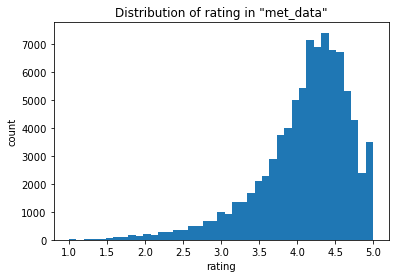

In [148]:
plt.hist(met_data.rating, bins=41)
plt.title("Distribution of rating in \"met_data\"")
plt.xlabel("rating")
plt.ylabel("count")
plt.show()

‎

This time I had a lot of troubles with "**CVGridSearch**", and some compromises had to be made. The biggest one being that pipelines will not work well.

Here is how things will go:

1. One hot encoding the whole data set.
2. Scale the data.
3. Impute the missing values with KNN.
4. Split the data into train, val, test.
5. Model.

‎

In [149]:
main_pipe2 = make_pipeline(FunctionTransformer(GetDumies), 
                           MinMaxScaler(), 
                           KNNImputer())

In [150]:
met_scaled_imp = pd.DataFrame(main_pipe2.fit_transform(met_data), columns = pd.get_dummies(met_data).columns)

In [151]:
# X, y separation.
met_att = met_scaled_imp[met_scaled_imp.columns[:-3]]
met_target = met_scaled_imp[met_scaled_imp.columns[-3:]]

In [152]:
# train_val, test split.
met_att_train_val, met_att_test, met_target_train_val, met_target_test = train_test_split(met_att, met_target, stratify=met_target, test_size=10_000)

# train, val split.
met_att_train, met_att_val, met_target_train, met_target_val = train_test_split(met_att_train_val, met_target_train_val, stratify=met_target_train_val, test_size=7977)
met_att_train.shape, met_att_val.shape, met_att_test.shape, met_target_train.shape, met_target_val.shape, met_target_test.shape

((100000, 12), (7977, 12), (10000, 12), (100000, 3), (7977, 3), (10000, 3))

### 3.2. Modeling.
#### 3.2.1.  Base line model - Logistic Regression.
‎

The setup is pretty simple. The data set is large enough that cross validation is not needed, so I will use the validation attributes and target I separated earlier. Since I could not figure out how to do a grid search without cross validation and with a predefined validation set, I had to do it the old fashioned way - with for loops.

The fact that we have 3 classes complicates things a bit. I chose to go with a one versus rest classifier, which basically fits a classifier for each class and compares it to the rest.

Metrics for a multi-class problems are not that straight forward. As far as I read, in the multi-class case, micro-precision, micro-recall, micro-F1 and accuracy all give the same result (this was the case in my testing also). The macro versions of these scorers are not all the same. Soo micro or macro? Well both, the intuition is that micro score will be closer to how the worst classifier does, and macro will be close to the best. F1-macro will calculate f1 for each class and average them.

‎

In [153]:
best_score = 0
best_model = None
combos = [["C", "fit_intercept", "train_score_micro", "val_score_micro"]]

for C in [1e-3, 1, 1e3, 1e6, 1e9]:
    for fit_intercept in [True, False]:
        log_res_model = OneVsRestClassifier(LogisticRegression(C=C, fit_intercept=fit_intercept), n_jobs=-2).fit(met_att_train, met_target_train)
        score_val = log_res_model.score(met_att_val, met_target_val)
        score_train = log_res_model.score(met_att_train, met_target_train)
        combos.append([C, fit_intercept, score_train, score_val])
        
        if score_val > best_score:
            best_score = score_val
            best_model = log_res_model
            
log_res_model = best_model

In [154]:
combos

[['C', 'fit_intercept', 'train_score_micro', 'val_score_micro'],
 [0.001, True, 0.06498, 0.06719318039363169],
 [0.001, False, 0.01988, 0.01993230537796164],
 [1, True, 0.23736, 0.23993982700263256],
 [1, False, 0.19423, 0.19531152062178764],
 [1000.0, True, 0.23839, 0.24044126864736115],
 [1000.0, False, 0.19846, 0.19794408925661275],
 [1000000.0, True, 0.23843, 0.24044126864736115],
 [1000000.0, False, 0.19794, 0.19694120596715559],
 [1000000000.0, True, 0.23826, 0.24019054782499685],
 [1000000000.0, False, 0.19821, 0.19706656637833772]]

In [155]:
log_res_model.estimators_[0].coef_

array([[-1.28001257, -1.30458737, -0.82329689, -0.50478511,  0.20241613,
         4.61307114,  0.2868424 , -0.47545758,  0.56090656,  0.02238293,
         1.2174399 ,  0.75485757]])

‎

And of course, we need a neat little function to print out all the scores we are interested in.

‎

In [156]:
def get_scores(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Print scoring metrics for evaluating models.
    """
    print(f"Best params {model.estimator.get_params}")
    print(f"train score - micro: {model.score(X_train, y_train)}, macro: {f1_score(model.predict(X_train), y_train, average='macro')}")
    print(f"val score - micro: {model.score(X_val, y_val)}, macro: {f1_score(model.predict(X_val), y_val, average='macro')}")
    print(f"test score - micro: {model.score(X_test, y_test)}, macro: {f1_score(model.predict(X_test), y_test, average='macro')}")

In [157]:
get_scores(log_res_model, 
           met_att_train, met_target_train, 
           met_att_val, met_target_val, 
           met_att_test, met_target_test)

Best params <bound method BaseEstimator.get_params of LogisticRegression(C=1000.0)>
train score - micro: 0.23839, macro: 0.3124761199686734
val score - micro: 0.24044126864736115, macro: 0.31280307448252137
test score - micro: 0.2383, macro: 0.31520850083028634


The base model really is too simplistic. Basically if a monkey clicked buttons at random to predict the class it would get similar results. Let's have a look at some more metrics. We need to go deeper.

‎

An interesting charachteristic to look at is how sure the model is in every prediction, or more importantly, how many predictions the model is uncertain of. Since the model is not performing too well, the model predicts around 50% for quite a few examples.

In [158]:
def get_uncertain_prediction_counts(model, X, y, interval=(0.49, 0.51)):
    """
    Print the count of unsure guesses for each class.
    """
    low_bound, high_bound = interval
    
    # y = label_binarize(y, classes=[1, 2, 3, 4, 5])
    n_classes = y.shape[1]
    labels = y.columns
    
    print("Uncertain value counts per class (ovr).\n")

    for i in range(n_classes):
        print(f"class {labels[i]}: {len([proba for proba in model.predict_proba(X)[:, i] if low_bound < proba < high_bound])}")

In [159]:
get_uncertain_prediction_counts(log_res_model, met_att_test, met_target_test)

Uncertain value counts per class (ovr).

class category_Entertainment: 37
class category_Music & Audio: 262
class category_Tools: 212


‎

Further insight can be had if we look at the multi-class confusion matrix represented as a heat map.

‎

In [160]:
def multi_class_confusion_matrix(model, X, y):
    """
    Confusion matrix - heat map.
    """
    class_labels = y.columns
    X = np.array(X)
    y = np.array(y)
    cm = confusion_matrix(y.argmax(axis=1), model.predict(X).argmax(axis=1))
    # cm = confusion_matrix(y, model.predict(X))
    plt.figure(figsize=(6, 5))
    sn.heatmap(cm, annot=True, fmt='.0f', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

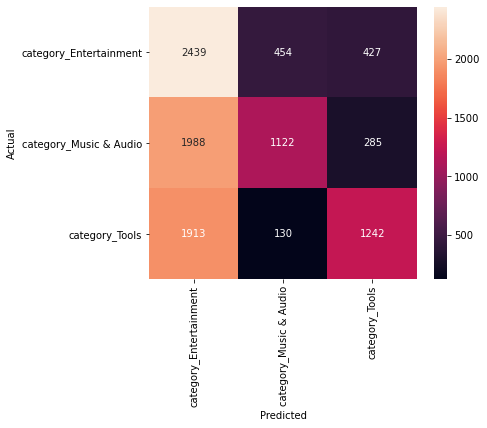

In [161]:
multi_class_confusion_matrix(log_res_model, met_att_test, met_target_test)

Unfortunately this is a very messy confusion matrix. Seems like we have the most troube with the "Entertainment" category, the model has a hard time differantiating it from the other two.

‎

Lastly, we can have a look at the ROC curve for each classifier. Also the function was basically copied from the sk_learn website - big thanks to them (https://scikit-learn.org/0.15/auto_examples/plot_roc.html).

In [162]:
def plot_multiclass_roc_curve(model, X_test, y_test, title="ROC"):
    """
    Plot ROC curve, and calculate AUC.
    """
    
    #y_test = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
    n_classes = y_test.shape[1]
    labels = y_test.columns
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure(figsize=(9, 9))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})')
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], '--', c="black")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

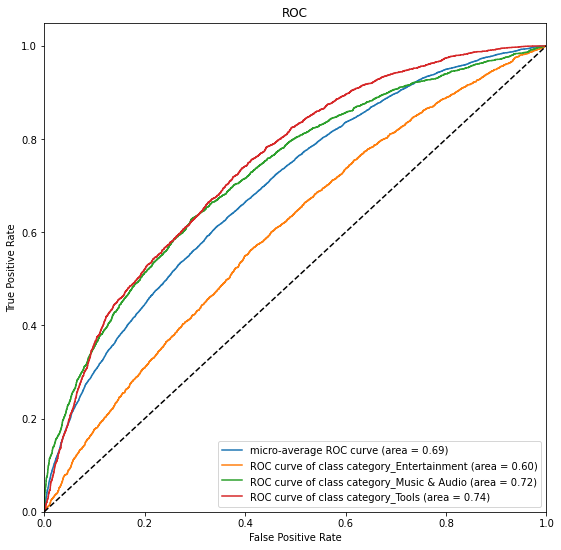

In [163]:
plot_multiclass_roc_curve(log_res_model, met_att_test, met_target_test)

Above are plotted the ROC curves for each class versus the rest. The yellow line is the class the model is having troubles with.

‎

#### 3.2.2 Logistic regression + polynomial features.

The first model proved too simplistic for the data. It had high bias. An easy way to to "upgrade" the first model is to take in account the interactions between the columns, almost like an automatic feature engineer. This can be done with "**PolinomialFeatures()**".

‎

In [164]:
met_att_poly = PolynomialFeatures().fit_transform(met_att)
met_att_poly.shape

(117977, 91)

In [165]:
poly_att_train_val, poly_att_test, poly_target_train_val, poly_target_test = train_test_split(met_att_poly, met_target, stratify=met_target, test_size=10_000)
# met_att_train.shape, met_att_test.shape, met_target_train.shape, met_target_test.shape

poly_att_train, poly_att_val, poly_target_train, poly_target_val = train_test_split(poly_att_train_val, poly_target_train_val, stratify=poly_target_train_val, test_size=7977)
poly_att_train.shape, poly_att_val.shape, poly_att_test.shape, poly_target_train.shape, poly_target_val.shape, poly_target_test.shape

((100000, 91), (7977, 91), (10000, 91), (100000, 3), (7977, 3), (10000, 3))

In [166]:
best_score = 0
best_model = None
combos = [["C", "fit_intercept", "train_score", "val_score"]]

for C in [1e-3, 1, 1e3, 1e6, 1e9]:
    for fit_intercept in [True, False]:
        log_res_poly_model = OneVsRestClassifier(LogisticRegression(C=C, fit_intercept=fit_intercept), 
                                                 n_jobs=-2).fit(poly_att_train, poly_target_train)
        
        score_val = log_res_poly_model.score(poly_att_val, poly_target_val)
        score_train = log_res_poly_model.score(poly_att_train, poly_target_train)
        combos.append([C, fit_intercept, score_train, score_val])
        
        if score_val > best_score:
            best_score = score_val
            best_model = log_res_poly_model
            
log_res_poly_model = best_model

In [167]:
combos

[['C', 'fit_intercept', 'train_score', 'val_score'],
 [0.001, True, 0.18845, 0.17725962141155824],
 [0.001, False, 0.15533, 0.1467970414942961],
 [1, True, 0.28551, 0.2757929046007271],
 [1, False, 0.28493, 0.27491538172245206],
 [1000.0, True, 0.28667, 0.27792403159082363],
 [1000.0, False, 0.28908, 0.28030587940328444],
 [1000000.0, True, 0.29102, 0.2814341231039238],
 [1000000.0, False, 0.28801, 0.2780493920020058],
 [1000000000.0, True, 0.28808, 0.28055660022564877],
 [1000000000.0, False, 0.29104, 0.28105804187037736]]

In [168]:
get_scores(log_res_poly_model, 
           poly_att_train, poly_target_train, 
           poly_att_val, poly_target_val, 
           poly_att_test, poly_target_test)

Best params <bound method BaseEstimator.get_params of LogisticRegression(C=1000000.0)>
train score - micro: 0.29102, macro: 0.3709223906978803
val score - micro: 0.2814341231039238, macro: 0.36213194626281364
test score - micro: 0.298, macro: 0.37556561221039164


‎

The model is still having trouble with the data.

‎

In [169]:
get_uncertain_prediction_counts(log_res_poly_model, poly_att_test, poly_target_test)

Uncertain value counts per class (ovr).

class category_Entertainment: 181
class category_Music & Audio: 215
class category_Tools: 192


‎

Still quite a few 50-percenters.

‎

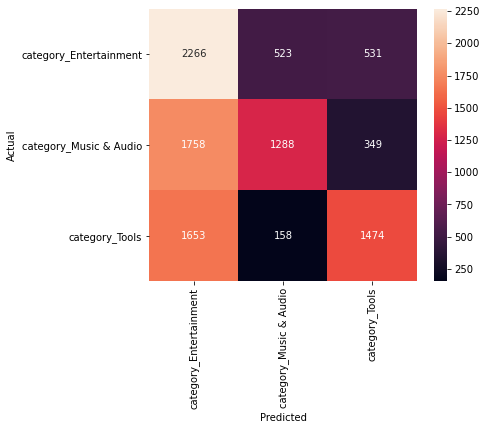

In [170]:
multi_class_confusion_matrix(log_res_poly_model, poly_att_test, poly_target_test)

Same problems, class "Entertainment" seems very hard to seperate. The good news is that there are more bright colours on the main diagonal.

‎

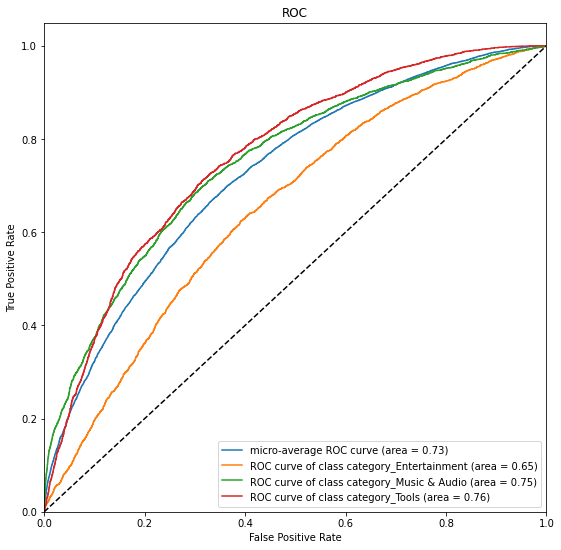

In [171]:
plot_multiclass_roc_curve(log_res_poly_model, poly_att_test, poly_target_test)

Not much change in the line department.

‎

#### 3.2.3. Radnom forest.

Turns out that an even more advanced model is need.

Random forest's strenght comes in numbers - the algorithm performs best when there are **many shallow trees**. Each tree can achieve some kind of separation and as a whole by majority voting great results can be achieved.

‎

In [172]:
best_score = 0
best_model = None
combos = [["n_estimators", "max_depth", "score_train", "score_val"]]

for n_estimators in [100, 200, 300]:
    for max_depth in [2, 5, 7, 10]:
        RFC_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=n_estimators, 
                                                               max_depth=max_depth), n_jobs=-2).fit(met_att_train, met_target_train)
        score_val = RFC_model.score(met_att_val, met_target_val)
        score_train = RFC_model.score(met_att_train, met_target_train)
        combos.append([n_estimators, max_depth, score_train, score_val])
        
        if score_val > best_score:
            best_score = score_val
            best_model = RFC_model
            
RFC_model = best_model

In [173]:
combos

[['n_estimators', 'max_depth', 'score_train', 'score_val'],
 [100, 2, 0.03806, 0.0383602858217375],
 [100, 5, 0.21831, 0.22101040491412813],
 [100, 7, 0.29755, 0.2974802557352388],
 [100, 10, 0.37071, 0.35602356775730226],
 [200, 2, 0.03731, 0.03710668170991601],
 [200, 5, 0.20956, 0.20872508461827755],
 [200, 7, 0.29571, 0.29321800175504575],
 [200, 10, 0.36731, 0.35288955747774853],
 [300, 2, 0.03077, 0.032468346496176505],
 [300, 5, 0.20825, 0.2085997242070954],
 [300, 7, 0.29438, 0.2924658392879529],
 [300, 10, 0.37117, 0.3551460448790272]]

In [174]:
RFC_model.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': 10,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(max_depth=10),
 'n_jobs': -2}

In [175]:
get_scores(RFC_model, 
           met_att_train, met_target_train, 
           met_att_val, met_target_val, 
           met_att_test, met_target_test)

Best params <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=10)>
train score - micro: 0.37071, macro: 0.46294006468508053
val score - micro: 0.35602356775730226, macro: 0.44402971257920876
test score - micro: 0.3534, macro: 0.4401124684915551


‎

This is a small breakthrough. It is notable that micro and macro scores are closer than in the other examples. That most likely means that we now more successfully separate the troublesome category "entertainment".

‎

In [176]:
get_uncertain_prediction_counts(RFC_model, met_att_test, met_target_test)

Uncertain value counts per class (ovr).

class category_Entertainment: 137
class category_Music & Audio: 225
class category_Tools: 243


‎

This is a bit strange. Although the matrics are better, the model is not very sure for a lot of predictions.

‎

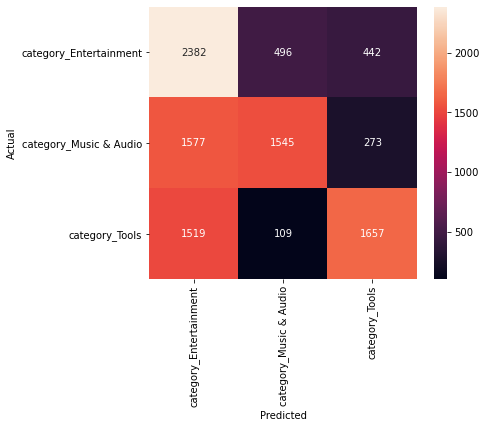

In [177]:
multi_class_confusion_matrix(RFC_model, met_att_test, met_target_test)

An indeed, there is more "flashing" along the main diagonal and less in the "Entertainment column", but still not enough.

‎

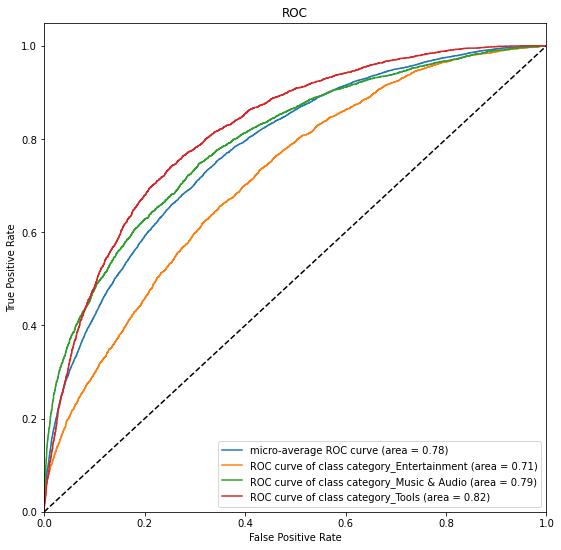

In [178]:
plot_multiclass_roc_curve(RFC_model, met_att_test, met_target_test)

‎

Finally the ROC curves look more bowed out and capture more area under themselves.

Last but not least - feature importances.

‎

In [179]:
for col, imp in zip(pd.get_dummies(met_data).columns, RFC_model.estimators_[0].feature_importances_):
    print(col, imp)

rating 0.14809027970664684
rating_count 0.08180838532435501
minimum_installs 0.03403783714793951
maximum_installs 0.04098374649576085
free 0.0061836397236196385
price 0.02615465476479471
size_M 0.2864882566479339
last_updated 0.12622771407111158
ad_supported 0.10419849318010245
in_app_purchases 0.029536206026706858
editors_choice 0.0006103343932174276
released_unix_timestamp 0.11568045251781127


‎

#### 3.2.4. The "final" frontier - SVC.

It is time to rip out the big guns. There is one problem, the data contains a lot of columns, and my laptop breaks a sweat when running minecraft. I had this particular classifier run for about 10 hours, and it spat out 3 (out of 5) results, which I humbly wrote down on a piece of paper:

* C, train, val
* C=1e-3, 0.0, 0.0
* C=1, 0.21688, 0.2176256738122101
* C=1e3, 0.28089 0.2796790773473737

So the data frame is too big for this classifier, but what if we exploit the law of big numbers? If we under sample the data, we lower the time to train, but retain the distributions inside the data.

‎

In [180]:
met_under_sample = met_scaled_imp.sample(20_000)

In [181]:
# separrate X, y.
und_att = met_under_sample[met_scaled_imp.columns[:-3]]
und_target = met_under_sample[met_scaled_imp.columns[-3:]]

‎

Train, validation, test split.

‎

In [182]:
und_att_train_val, und_att_test, und_target_train_val, und_target_test = train_test_split(und_att, und_target, stratify=und_target, test_size=4_000)
und_att_train, und_att_val, und_target_train, und_target_val = train_test_split(und_att_train_val, und_target_train_val, stratify=und_target_train_val, test_size=3_000)
und_att_train.shape, und_att_val.shape, und_att_test.shape, und_target_train.shape, und_target_val.shape, und_target_test.shape

((13000, 12), (3000, 12), (4000, 12), (13000, 3), (3000, 3), (4000, 3))

‎

The "golden diagonal" of values is valid here too - small gamma (big area of influence) + large "C" value.

‎

In [183]:
best_score = 0
best_model = None
combos = [["C", "gamma", "score_train", "score_val"]]

for C in [0.1, 1, 10, 100, 1e3]:
    for gamma in [0.01, 0.1, 10]:
        SVC_rbf_model = OneVsRestClassifier(SVC(C=C, gamma=gamma), n_jobs=-2).fit(und_att_train, und_target_train)
        score_val = SVC_rbf_model.score(und_att_val, und_target_val)
        score_train = SVC_rbf_model.score(und_att_train, und_target_train)
        combos.append([C, gamma, score_train, score_val])

        if score_val > best_score:
            best_score = score_val
            best_model = SVC_rbf_model
            
SVC_rbf_model = best_model

In [184]:
combos

[['C', 'gamma', 'score_train', 'score_val'],
 [0.1, 0.01, 0.0, 0.0],
 [0.1, 0.1, 0.17507692307692307, 0.177],
 [0.1, 10, 0.236, 0.228],
 [1, 0.01, 0.17515384615384616, 0.177],
 [1, 0.1, 0.14492307692307693, 0.14466666666666667],
 [1, 10, 0.30023076923076925, 0.2936666666666667],
 [10, 0.01, 0.2003076923076923, 0.19766666666666666],
 [10, 0.1, 0.17023076923076924, 0.176],
 [10, 10, 0.33053846153846156, 0.31433333333333335],
 [100, 0.01, 0.1513076923076923, 0.15266666666666667],
 [100, 0.1, 0.22153846153846155, 0.22233333333333333],
 [100, 10, 0.35415384615384615, 0.329],
 [1000.0, 0.01, 0.17007692307692307, 0.17666666666666667],
 [1000.0, 0.1, 0.23576923076923076, 0.23433333333333334],
 [1000.0, 10, 0.38076923076923075, 0.3403333333333333]]

In [185]:
SVC_rbf_model.get_params()

{'estimator__C': 1000.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 10,
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(C=1000.0, gamma=10),
 'n_jobs': -2}

In [186]:
get_scores(RFC_model, 
           und_att_train, und_target_train, 
           und_att_val, und_target_val, 
           und_att_test, und_target_test)

Best params <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=10)>
train score - micro: 0.3676923076923077, macro: 0.46056973432424125
val score - micro: 0.37066666666666664, macro: 0.46139233408291963
test score - micro: 0.3505, macro: 0.4442698843622909


‎

This is another step up from the last model and we only used 20% of the data.

‎

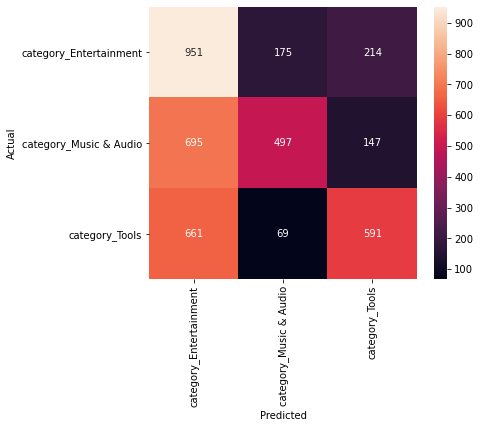

In [187]:
multi_class_confusion_matrix(SVC_rbf_model, und_att_test, und_target_test)

‎

Class "Entertainment" is still the stumbling block. So far this is the best model, I am going to pickle it.

SVR does not have "predict_proba" by default (can be enabled), so no ROC curve or count of uncertain predictions.

‎

In [188]:
pickle.dump(SVC_rbf_model, open('SVC_rbf_model.pkl', 'wb'))

‎

### 4. Previous work.

Most projects with this data set center around predicting rating. There are no direct comparisons to what I have done.

‎

### 5. Feature work.

* Doing regression for rating with the 600k data set might yield some strong results.
* Trying to predict other categories.
* Somehow incorporate deep learning.
* The first data set comes with a comments data set (which I have excluded). Sentiment analysis on that might boost the "low rating" predictions.

‎

### 6. Closure on the entire project.

Data is powerful, but it cannot predict everything. In this case I feel like the data was the limiting factor. The results for rating an app were not that bad, a "sophisticated calculator" rating apps within 0.3 stars from a human - at least I consider it rather impressive. The classification results were not that great, maybe it was too much to ask for.

This was an amazing learning experience. So many things went wrong, I found so many mistakes and probably have still not caught some obvious ones. But when pieces of the puzzle seemingly pop in the right place - man is that satisfying. 

‎

P.S. About that "lost" part of the project, in the end I decided to not include it, but I will briefly explain where the problem was.

I wanted to predict "rating" which is a continuous variable, but in this case has 41 distinct values. To predict 41 classes seems too much, so I decided to round the ratings and predict 5 classes (1, 2, 3, 4, 5). This is a lot less classes, but something happened to the distribution.

![ultra_imbalanced](https://imgur.com/QsYyHKA.jpg)

In a single step I made the data set ultra imbalanced. This looks super obvious, but I only found out when I wondered why all the models are doing very badly.

‎

#### Citations:

* Data structures for statistical computing in python, McKinney, Proceedings of the 9th Python in Science Conference, Volume 445, 2010.
* Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

#### References:

* Imputation - https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation
* Multi-class confusion matrix - https://stackoverflow.com/questions/49330195/how-to-use-inverse-transform-in-minmaxscaler-for-a-column-in-a-matrix
* Multi-class metrics - https://stackoverflow.com/questions/37358496/is-f1-micro-the-same-as-accuracy https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
* SVR tuning - https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html https://tomaszkacmajor.pl/index.php/2016/04/24/svm-model-selection/
* Residual plots - https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/
* Pipelines - http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html https://www.kaggle.com/marloz/sklearn-pipelines-missing-values
* And many more...